Workflow for Getting Throw Types

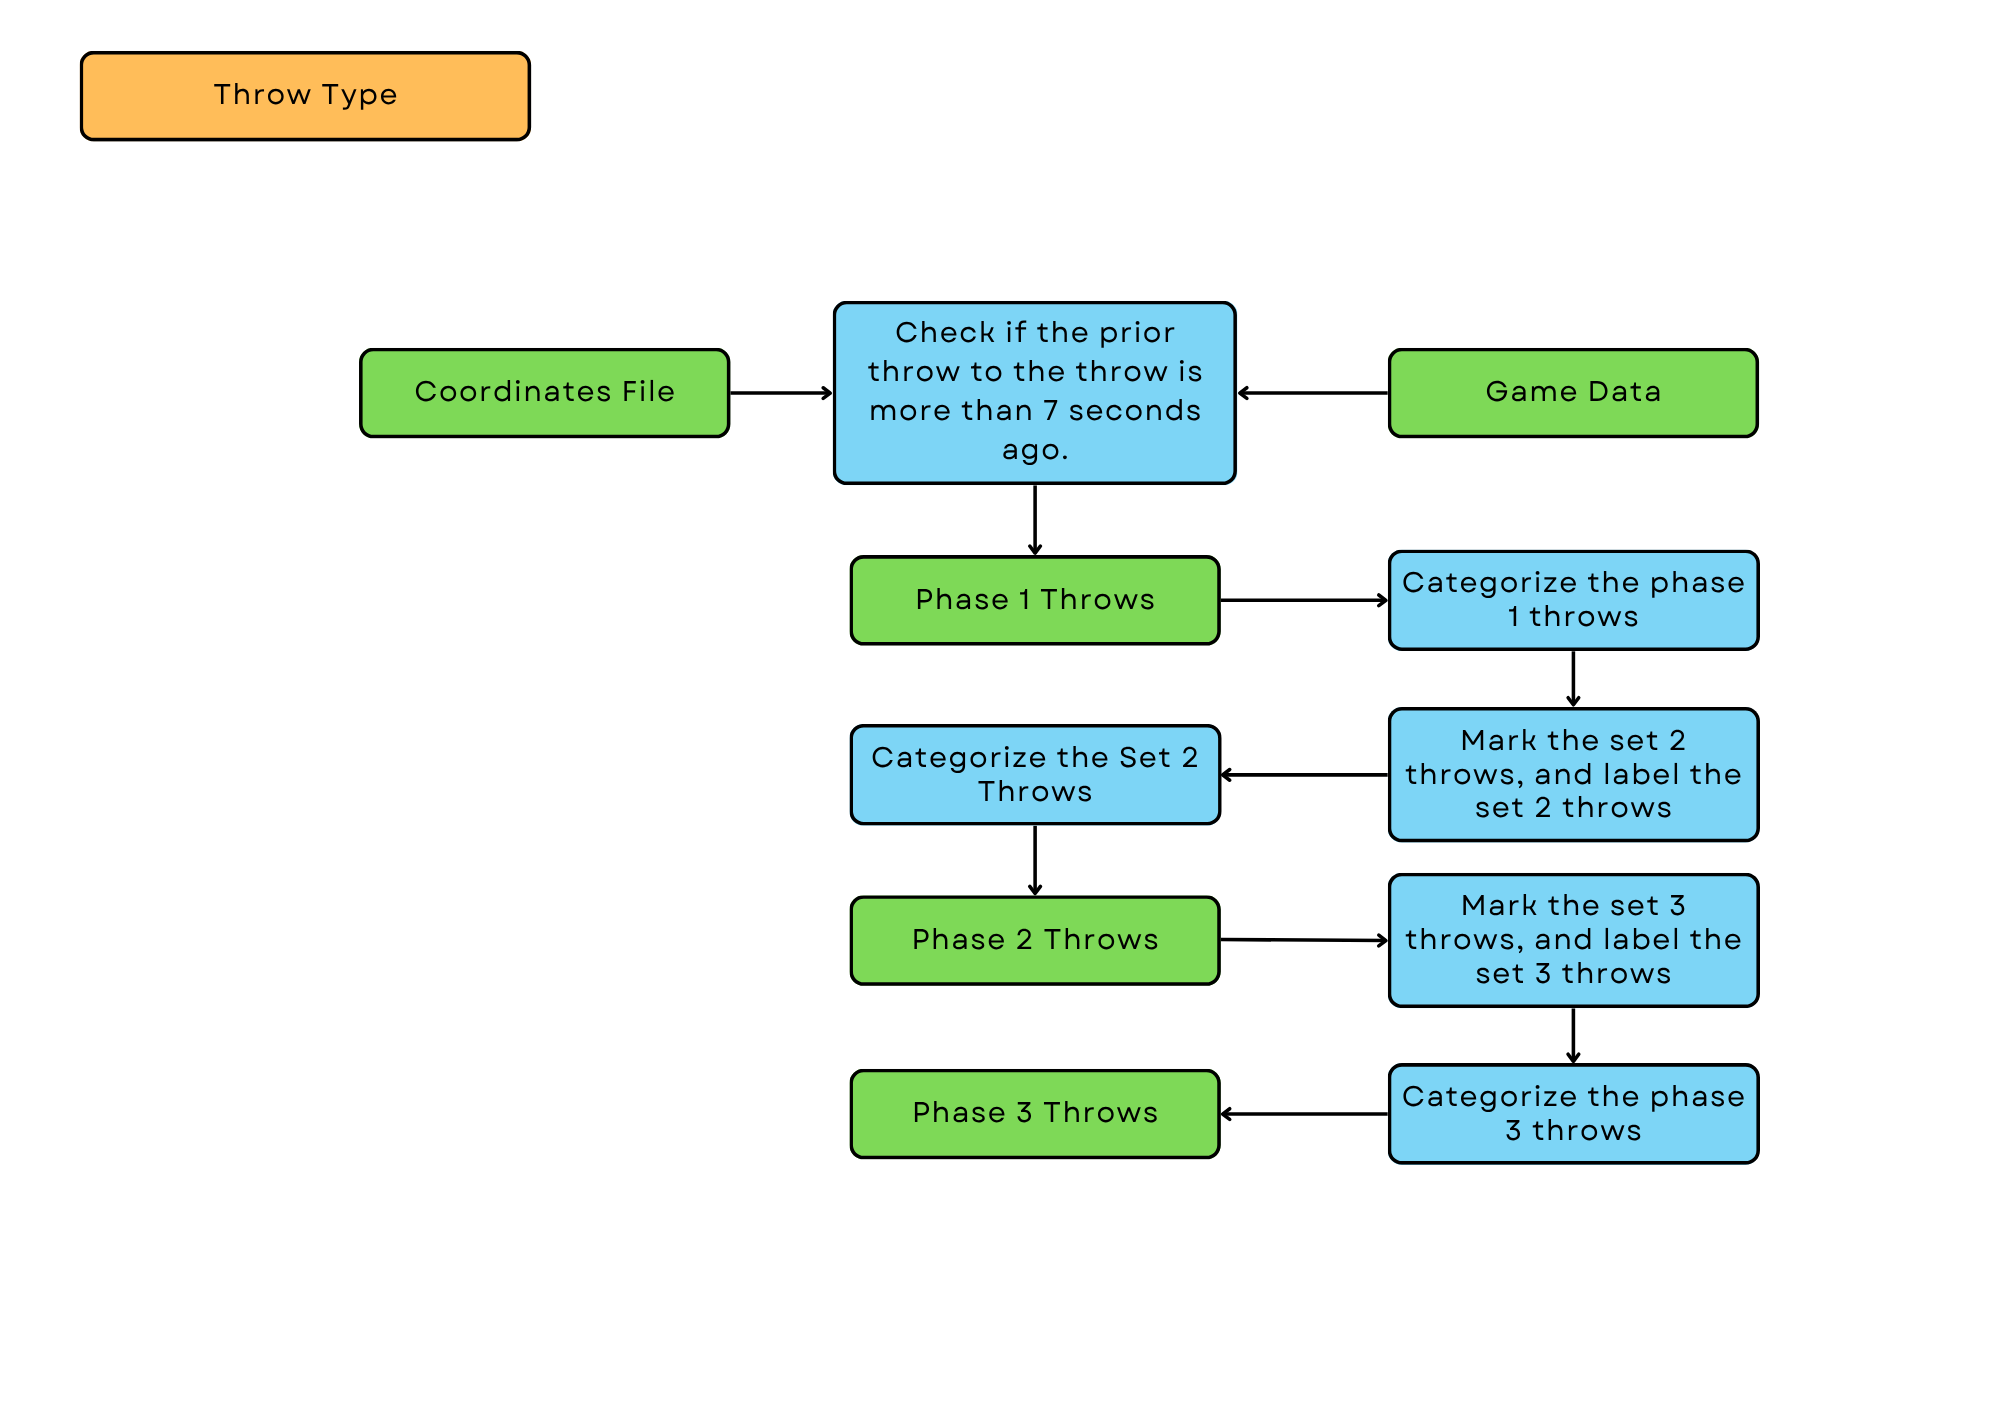

Overview of Throw Types

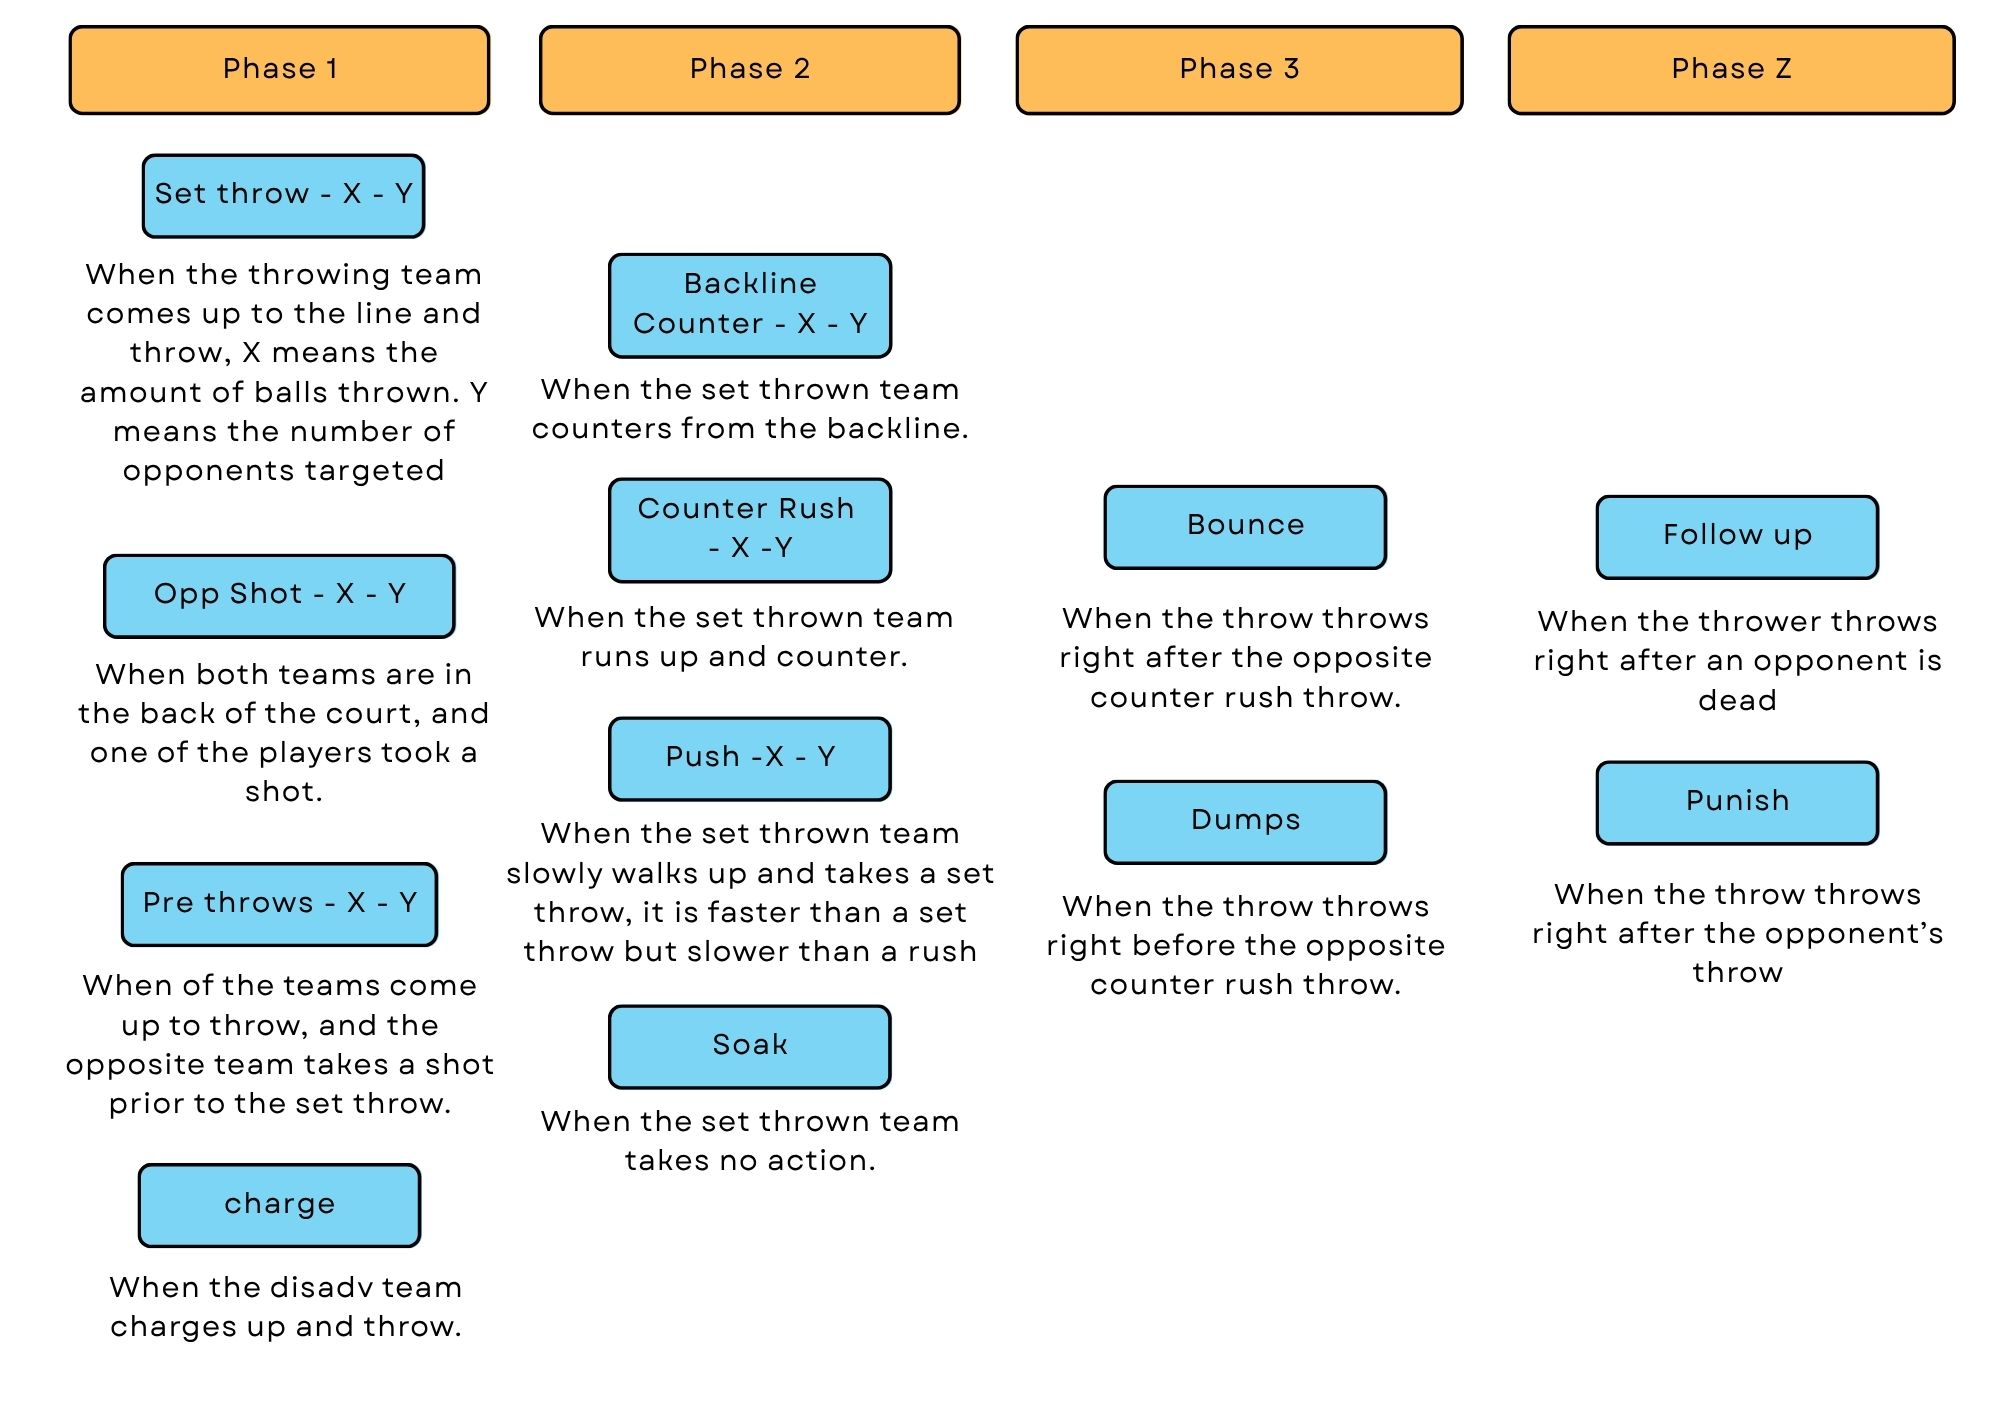

Zone Definitions

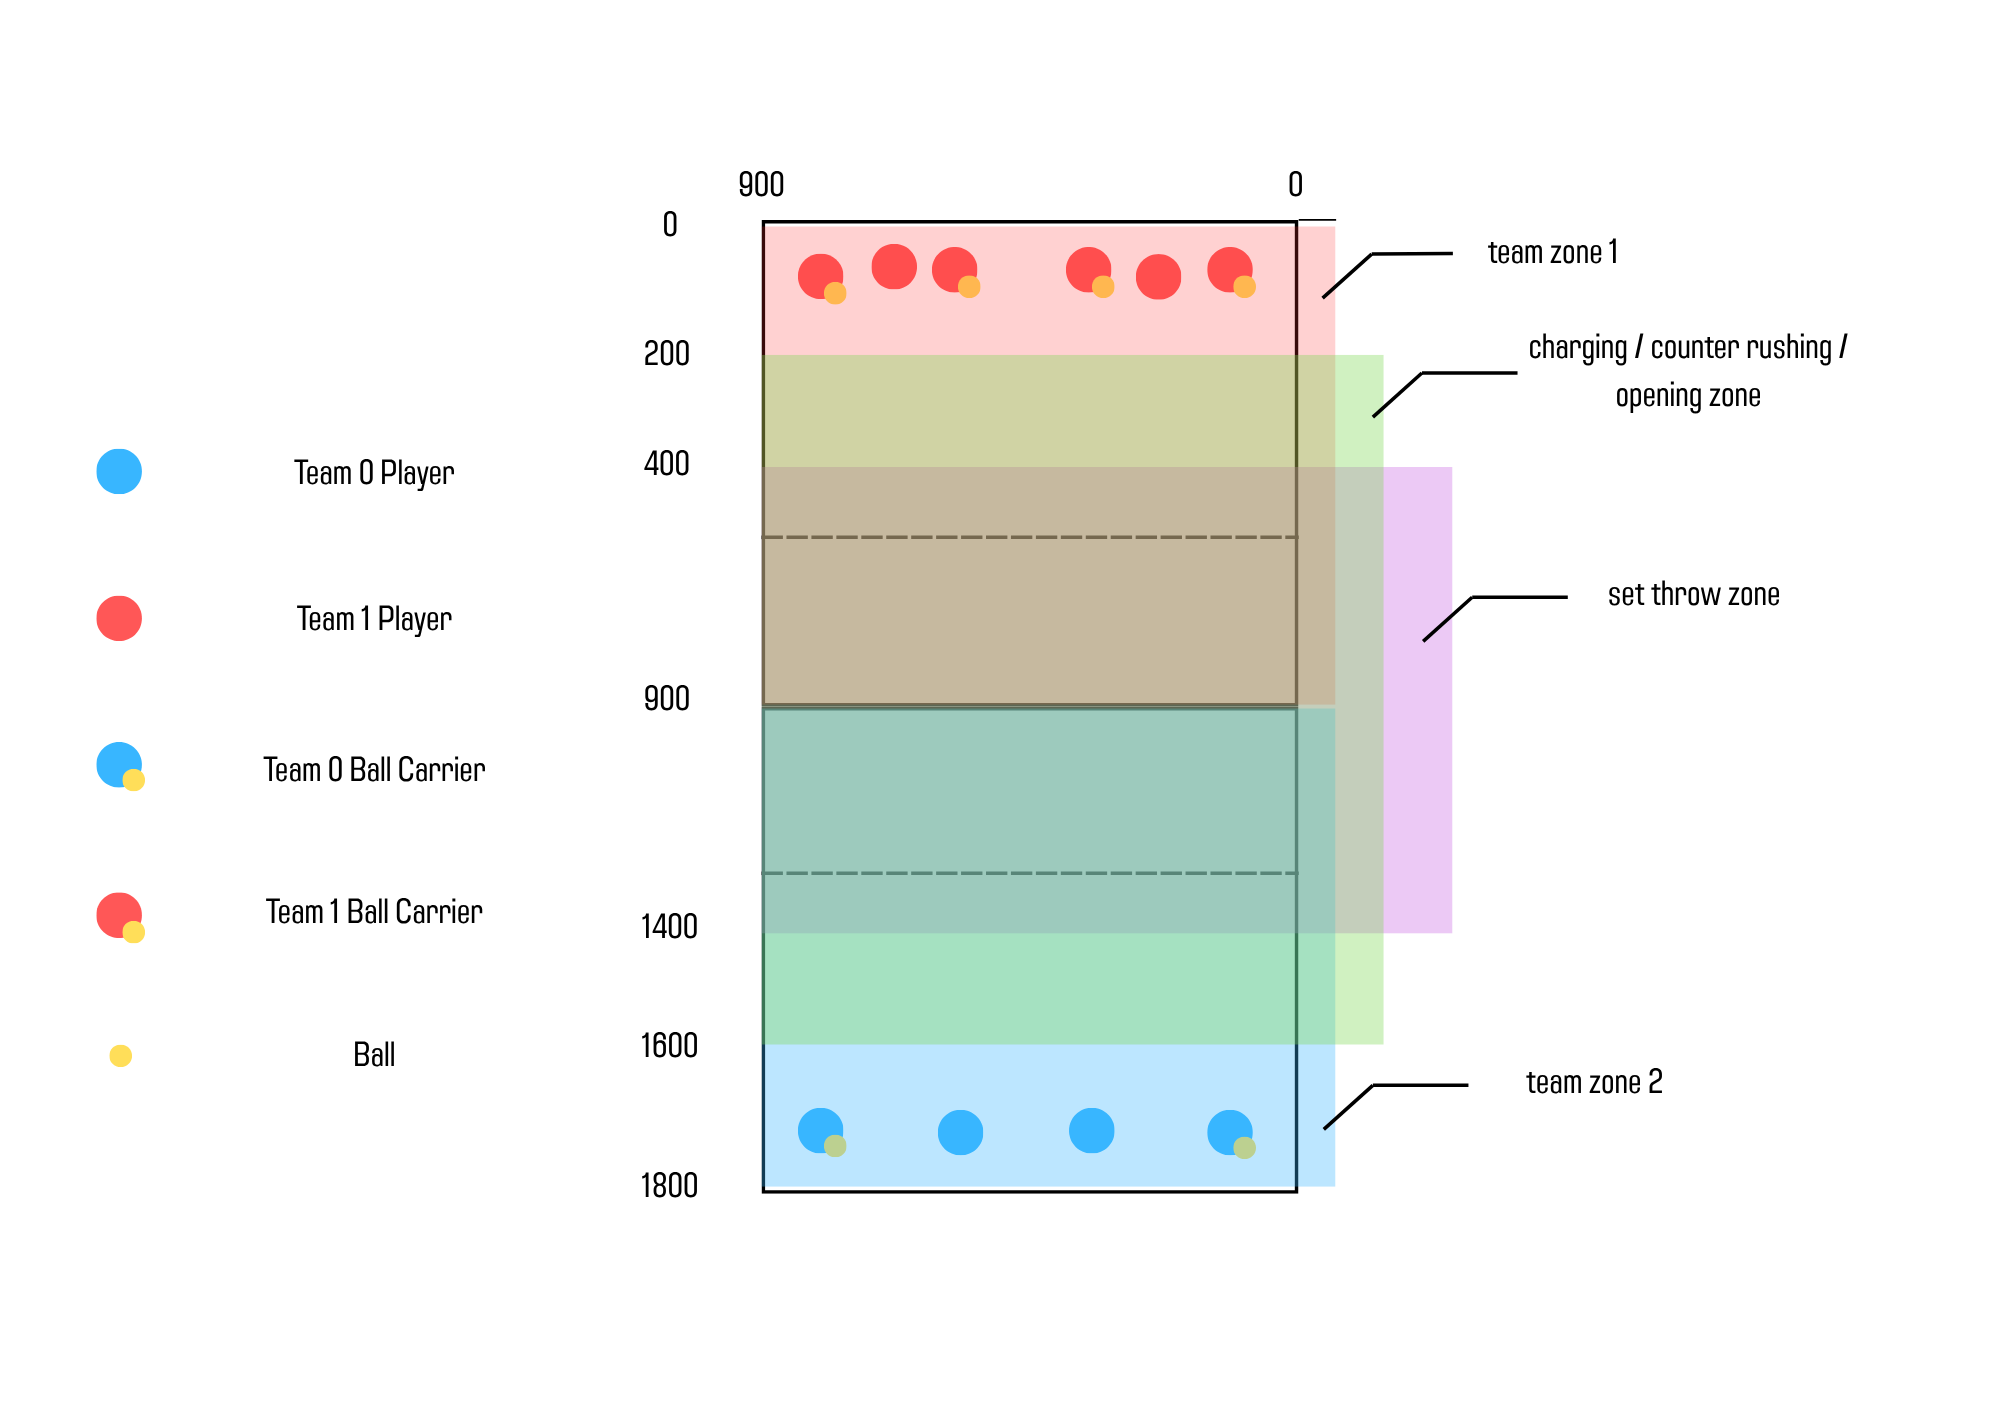

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Inzone players in various zones



set throw zone:

charge zone:

counter rush zone:

counter zone:




Phase 1 throws - set throw, opp shot, pre throws, charge

In [ ]:
import os, glob
import numpy as np
import pandas as pd

# ========= CONFIG =========
ROOT = '/content/drive/MyDrive/Winrate predictions'   # folder with "<reviewId>_data_files" subfolders
LOOKBACK_SEC   = 7.0
SWITCH_THRESHOLD = 1200.0    # first set that STARTS after this time triggers court swap for remainder
INHERIT_WINDOW  = 1.2        # same-team quick follow-up inherits prior category (OVERRIDES EVERYTHING)
BACKLINE_WINDOW = 2.5        # ≤ 2.5s -> backline/counter_rush
COUNTER_WINDOW  = 3.5        # ≤ 3.5s -> counter_rush
BOUNCE_WINDOW   = 2.0        # ≤ 2.0s after counter/backline from the OTHER team -> bounce

# Base court Y ranges (before switch)
T1_ZONE = (500, 900)         # Team 1 set-throw zone (base)
T0_ZONE = (900, 1300)        # Team 0 set-throw zone (base)

# Opening rush expanded zones (before switch)
OPEN_T1_ZONE = (200, 900)    # Team 1 opening rush zone (base)
OPEN_T0_ZONE = (900, 1600)   # Team 0 opening rush zone (base)

# Mid-range windows
MID_RANGE       = (200, 1600)   # pre/charge (throwing team)
MID_300_1500    = (300, 1500)   # backline/counter_rush/dump
PUSH_500_1400   = (500, 1400)   # push

# ========= HELPERS =========
def is_throw_row(title, definitionKey):
    t = str(title).lower(); d = str(definitionKey).lower()
    return ('throw' in t) or ('throw' in d)

def is_got_targeted_row(title, definitionKey):
    t = str(title).lower(); d = str(definitionKey).lower()
    return ('got targeted' in t) or ('got_targeted' in d)

def is_throw_hit_row(title, definitionKey):
    t = str(title).lower(); d = str(definitionKey).lower()
    return ('throw hit' in t) or ('throw_hit' in d)

def load_game_paths(game_folder):
    g = sorted(glob.glob(os.path.join(game_folder, '*_game_data.xlsx')))
    c = sorted(glob.glob(os.path.join(game_folder, '*_throw_coordinates_combined.xlsx')))
    if not g or not c: return None, None
    return g[0], c[0]

def normalize_teams(series):
    s = pd.to_numeric(series, errors='coerce')
    return (s == 1).astype(int)   # exactly 1 -> 1, else 0

def prepare_events(df):
    df['title'] = df.get('title', '').astype(str)
    df['definitionKey'] = df.get('definitionKey', '').astype(str)
    df['who'] = df.get('who', '').astype(str).str.strip()
    df['time'] = pd.to_numeric(df.get('time', np.nan), errors='coerce')
    df['team'] = normalize_teams(df.get('team', np.nan))
    df['is_throw'] = df.apply(lambda r: is_throw_row(r['title'], r['definitionKey']), axis=1)

    # Phase-1 = throw with >=7s since previous throw
    def tag_phase1(g):
        g = g.sort_values('time')
        tt = g.loc[g['is_throw'], 'time']; prev = tt.shift(1)
        g.loc[g['is_throw'], 'is_phase1'] = (prev.isna()) | ((tt - prev) > LOOKBACK_SEC)
        return g

    df['is_phase1'] = False
    df = tag_phase1(df)
    df['is_phase1'] = df['is_phase1'].fillna(False).astype(bool)

    # Sets from “Won Round” / “Lost Round”
    boundary = df['title'].str.strip().str.lower().isin(['won round', 'lost round'])
    df['set_no'] = boundary.cumsum().shift(fill_value=0) + 1

    # First throw of each set
    df['is_first_throw_of_set'] = False
    first_throw_idx = (df[df['is_throw']].sort_values(['set_no','time'])
                       .groupby('set_no', as_index=False).head(1).index)
    df.loc[first_throw_idx, 'is_first_throw_of_set'] = True
    return df

def compute_switch_time(events, threshold=SWITCH_THRESHOLD):
    ev = events.sort_values('time').reset_index(drop=True)
    boundary = ev['title'].str.strip().str.lower().isin(['won round', 'lost round'])
    ev['set_no'] = boundary.cumsum().shift(fill_value=0) + 1
    start_times = ev.groupby('set_no', as_index=True)['time'].min().sort_index()
    candidates = start_times[start_times > threshold]
    return None if candidates.empty else float(candidates.iloc[0])

def prepare_coords(df):
    df = df.rename(columns={'player_idx':'player_index','player_indx':'player_index'})
    need = ['time','throw_index','team','player_index','y']
    miss = [c for c in need if c not in df.columns]
    if miss: raise KeyError(f"Coords file missing: {miss}")
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    df['throw_index'] = pd.to_numeric(df['throw_index'], errors='coerce').astype('Int64')
    df['team'] = normalize_teams(df['team'])
    df['player_index'] = pd.to_numeric(df['player_index'], errors='coerce').astype('Int64')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df = (df.dropna(subset=['time','throw_index','team','player_index','y'])
            .sort_values(['time','team','player_index'])
            .drop_duplicates(['time','team','player_index'], keep='last'))
    return df

def coords_at_nearest_time(coords, t):
    if len(coords) == 0 or pd.isna(t): return coords.iloc[0:0]
    times = coords['time'].to_numpy()
    idx = int(np.argmin(np.abs(times - float(t))))
    nearest = times[idx]
    return coords[coords['time'] == nearest]

# ---- DOUBLE SWITCH (flip teams in snapshot + swap zones after post-1200 set) ----
def apply_double_switch(snapshot, after_switch):
    if snapshot.empty: return snapshot
    snap = snapshot.copy()
    snap['team_eff'] = np.where(after_switch, 1 - snap['team'], snap['team'])
    return snap

def zone_for_team_effective(team_val, after_switch):
    z1, z0 = T1_ZONE, T0_ZONE
    if after_switch: z1, z0 = T0_ZONE, T1_ZONE
    return z1 if team_val == 1 else z0

def opening_zone_for_team_effective(team_val, after_switch):
    z1, z0 = OPEN_T1_ZONE, OPEN_T0_ZONE
    if after_switch: z1, z0 = OPEN_T0_ZONE, OPEN_T1_ZONE
    return z1 if team_val == 1 else z0

def count_players_in_range(snapshot_eff, team_val, lo_hi):
    lo, hi = lo_hi
    m = (snapshot_eff['team_eff'] == team_val) & (snapshot_eff['y'] >= lo) & (snapshot_eff['y'] <= hi)
    return snapshot_eff.loc[m, 'player_index'].nunique()

def categorize_throw(throw_team, t, snapshot, after_switch, is_first_throw_of_set, is_phase1):
    snap_eff = apply_double_switch(snapshot, after_switch)
    if snap_eff.empty:
        return {'t0_zone': np.nan, 't1_zone': np.nan, 'throw_team_in_mid': np.nan, 'phase1_category': 'no_coords'}

    # Opening rush override
    if is_first_throw_of_set:
        t0_open = count_players_in_range(snap_eff, 0, opening_zone_for_team_effective(0, after_switch))
        t1_open = count_players_in_range(snap_eff, 1, opening_zone_for_team_effective(1, after_switch))
        if (t0_open > 0) and (t1_open > 0):
            return {'t0_zone': t0_open, 't1_zone': t1_open,
                    'throw_team_in_mid': count_players_in_range(snap_eff, throw_team, MID_RANGE),
                    'phase1_category': 'opening_rush_exchange'}

    # Regular Phase-1 categories
    t0c = count_players_in_range(snap_eff, 0, zone_for_team_effective(0, after_switch))
    t1c = count_players_in_range(snap_eff, 1, zone_for_team_effective(1, after_switch))
    if not is_phase1:
        return {'t0_zone': t0c, 't1_zone': t1c,
                'throw_team_in_mid': count_players_in_range(snap_eff, throw_team, MID_RANGE),
                'phase1_category': None}

    if t0c == 0 and t1c == 0:
        return {'t0_zone': t0c, 't1_zone': t1c,
                'throw_team_in_mid': count_players_in_range(snap_eff, throw_team, MID_RANGE),
                'phase1_category': 'opp_shot'}
    if t0c > t1c: zone_team = 0
    elif t1c > t0c: zone_team = 1
    else:
        return {'t0_zone': t0c, 't1_zone': t1c,
                'throw_team_in_mid': count_players_in_range(snap_eff, throw_team, MID_RANGE),
                'phase1_category': 'tie_in_zones'}

    if zone_team == throw_team:
        return {'t0_zone': t0c, 't1_zone': t1c,
                'throw_team_in_mid': count_players_in_range(snap_eff, throw_team, MID_RANGE),
                'phase1_category': 'set_throw'}

    in_mid = count_players_in_range(snap_eff, throw_team, MID_RANGE)
    return {'t0_zone': t0c, 't1_zone': t1c, 'throw_team_in_mid': in_mid,
            'phase1_category': ('pre_throw' if in_mid == 0 else 'charge_pre_throw')}

# ---- BETWEEN-PHASE label for the NEXT throw after a Phase-1 set_throw ----
def between_category_for_next(prev_row, next_row, coords, switch_time):
    if next_row['is_phase1']: return None
    set_throw_team  = int(prev_row['team'])
    set_thrown_team = 1 - set_throw_team
    dt = float(next_row['time']) - float(prev_row['time'])

    after_switch = (switch_time is not None) and pd.notna(next_row['time']) and (next_row['time'] >= switch_time)
    snap = coords_at_nearest_time(coords, next_row['time'])
    snap_eff = apply_double_switch(snap, after_switch)

    set_thrown_mid  = count_players_in_range(snap_eff, set_thrown_team, MID_300_1500)
    set_thrown_push = count_players_in_range(snap_eff, set_thrown_team, PUSH_500_1400)
    both_mid = (count_players_in_range(snap_eff, 0, MID_300_1500) > 0) and \
               (count_players_in_range(snap_eff, 1, MID_300_1500) > 0)

    if int(next_row['team']) == set_thrown_team:
        if dt <= BACKLINE_WINDOW:
            return 'backline_counter' if set_thrown_mid == 0 else 'counter_rush'
        elif dt <= COUNTER_WINDOW:
            if set_thrown_mid >= 1:
                return 'counter_rush'
        else:
            if set_thrown_push >= 2:
                return 'push'
    else:
        if both_mid:
            return 'dump'
    return None

PUNISH_WINDOW = 3.0  # seconds

def compute_punish_follow(events, throws_df):
    # Build a map: time -> list of names ('who') present at that exact time
    names_by_time = events.groupby('time')['who'].apply(list).to_dict()

    # Prior throw times per person (for punish)
    person_throw_times = {}
    ev_throws = events[events['is_throw']].dropna(subset=['who','time']).sort_values('time')
    for who, g in ev_throws.groupby('who'):
        person_throw_times[str(who)] = g['time'].to_numpy()

    # Team Throw Hit times (for follow_up)
    team_hit_times = {}
    ev_hits = events[events.apply(lambda r: is_throw_hit_row(r['title'], r['definitionKey']), axis=1)].sort_values('time')
    for team, g in ev_hits.groupby('team'):
        team_hit_times[int(team)] = g['time'].dropna().to_numpy()

    punish_flags, follow_flags = [], []
    for _, r in throws_df.iterrows():
        t = float(r['time'])
        team = int(r['team'])
        thrower = str(r.get('title_who', r.get('who', '')))  # throws_df may not carry 'who'; if it does, use it
        # If throws_df doesn't have 'who', pull from events at time t by matching team+time:
        if not thrower:
            # best-effort: get the thrower from events at t with same team and is_throw
            candidates = events[(events['time'] == t) & (events['team'] == team) & (events['is_throw'])]
            if len(candidates):
                thrower = str(candidates.iloc[0]['who'])

        # --- PUNISH: any same-time name (excluding the thrower) threw within last PUNISH_WINDOW seconds
        punished = False
        for target in names_by_time.get(t, []):
            if str(target) == thrower:
                continue  # don't punish yourself
            times = person_throw_times.get(str(target))
            if not times is None and len(times):
                idx = np.searchsorted(times, t, side='right') - 1  # last throw time strictly <= t
                if idx >= 0 and times[idx] >= t - PUNISH_WINDOW:
                    punished = True
                    break

        # --- FOLLOW-UP: a teammate's Throw Hit in [t-2.0, t) (strictly before current throw)
        follow = False
        hit_times = team_hit_times.get(team, np.array([]))
        if hit_times.size and np.any((hit_times >= t - 2.0) & (hit_times < t)):
            follow = True

        punish_flags.append(punished)
        follow_flags.append(follow)

    return pd.Series(punish_flags, index=throws_df.index), pd.Series(follow_flags, index=throws_df.index)

# ========= MAIN PER-GAME =========
def process_one_game(game_folder):
    game_path, coord_path = load_game_paths(game_folder)
    if not game_path or not coord_path:
        print(f"[skip] Missing files in {game_folder}"); return None

    review_id = os.path.basename(game_path).split('_game_data.xlsx')[0]
    events = prepare_events(pd.read_excel(game_path))
    coords  = prepare_coords(pd.read_excel(coord_path))
    switch_time = compute_switch_time(events, threshold=SWITCH_THRESHOLD)

    # Throws only, time-sorted
    throws = events[events['is_throw']].copy().sort_values('time').reset_index(drop=True)

    # First pass: base categories from coords
    raw_rows = []
    for _, r in throws.iterrows():
        t = float(r.get('time', np.nan)) if pd.notna(r.get('time', np.nan)) else np.nan
        team_val = int(r['team'])
        after_switch = (switch_time is not None) and (pd.notna(t)) and (t >= switch_time)
        snap = coords_at_nearest_time(coords, t)

        info = categorize_throw(
            throw_team=team_val,
            t=t,
            snapshot=snap,
            after_switch=after_switch,
            is_first_throw_of_set=bool(r['is_first_throw_of_set']),
            is_phase1=bool(r['is_phase1'])
        )

        raw_rows.append({
            'reviewId': review_id,
            'eventId': r.get('eventId', _),
            'time': t,
            'team': team_val,
            'after_switch': bool(after_switch),
            'is_phase1': bool(r['is_phase1']),
            'is_first_throw_of_set': bool(r['is_first_throw_of_set']),
            'title': r.get('title',''),
            'definitionKey': r.get('definitionKey',''),
            **info
        })

    out_df = pd.DataFrame(raw_rows).sort_values('time').reset_index(drop=True)

    # Inject between-phase label for the NEXT non-phase1 throw after a Phase-1 set_throw
    for i in range(len(out_df) - 1):
        curr, nxt = out_df.loc[i], out_df.loc[i+1]
        if curr['is_phase1'] and curr['phase1_category'] == 'set_throw' and not nxt['is_phase1']:
            bp = between_category_for_next(curr, nxt, coords, switch_time)
            if bp is not None:
                out_df.at[i+1, 'phase1_category'] = bp

    # Second pass: precedence (1.2s override FIRST), then ORE propagation
    final_cats = []
    ore_mode = False
    prev_time = prev_team = prev_final = None

    for i, r in out_df.iterrows():
        cat = r['phase1_category']

        # 1) 1.2s same-team inheritance (overrides everything)
        inherited = False
        if (prev_time is not None) and (r['team'] == prev_team) and ((r['time'] - prev_time) <= INHERIT_WINDOW):
            if prev_final not in (None, 'no_coords'):
                cat = prev_final
                inherited = True

        # ORE ends at any new Phase-1 throw
        if r['is_phase1']:
            ore_mode = False

        # 2) Opening-rush propagation (if not just inherited)
        if (not inherited) and ore_mode and (not r['is_phase1']):
            cat = 'opening_rush_exchange'

        # Turn on ORE propagation if this row is the ORE starter
        if r['is_first_throw_of_set'] and (cat == 'opening_rush_exchange'):
            ore_mode = True

        final_cats.append(cat)
        prev_time, prev_team, prev_final = r['time'], r['team'], cat

    out_df['phase1_category'] = final_cats

    # Third pass: BOUNCE (after counter_rush/backline_counter → other team within 2.0s)
    for i in range(len(out_df)-1):
        a, b = out_df.loc[i], out_df.loc[i+1]
        if a['phase1_category'] in ('backline_counter','counter_rush'):
            if (b['team'] != a['team']) and ((b['time'] - a['time']) <= BOUNCE_WINDOW):
                out_df.at[i+1, 'phase1_category'] = 'bounce'

    # Punish & Follow-up (booleans)
    punish_s, follow_s = compute_punish_follow(events, out_df)
    out_df['is_punish']   = punish_s.fillna(False).astype(bool)
    out_df['is_followup'] = follow_s.fillna(False).astype(bool)

    # Save per-game outputs
    out1 = os.path.join(game_folder, f'{review_id}_phase1_categorized_by_nearest_time.xlsx')
    out_df.to_excel(out1, index=False)

    # Merge back to full events
    ev = events.merge(
        out_df[['time','team','phase1_category','t0_zone','t1_zone','throw_team_in_mid',
                'after_switch','is_first_throw_of_set','is_punish','is_followup']],
        on=['time','team'], how='left'
    )
    out2 = os.path.join(game_folder, f'{review_id}_events_with_phase1_tags_by_nearest_time.xlsx')
    ev.to_excel(out2, index=False)

    print(f"[done] {review_id} -> {os.path.basename(out1)}, {os.path.basename(out2)}")
    return out_df

# ========= RUN ALL GAME FOLDERS =========
game_folders = sorted(glob.glob(os.path.join(ROOT, '*_data_files')))
summary = []
for gf in game_folders:
    res = process_one_game(gf)
    if isinstance(res, pd.DataFrame) and not res.empty:
        summary.append(res.assign(folder=os.path.basename(gf)))

if summary:
    summary_df = pd.concat(summary, ignore_index=True)
    summary_out = os.path.join(ROOT, 'phase1_categorization_summary_by_nearest_time.xlsx')
    summary_df.to_excel(summary_out, index=False)
    print(f"\nSaved cross-game summary -> {summary_out}")
else:
    print("No outputs generated (check folder structure/columns).")


[done] 01d7c3a8-0625-4e71-adc1-6420cc0f5390 -> 01d7c3a8-0625-4e71-adc1-6420cc0f5390_phase1_categorized_by_nearest_time.xlsx, 01d7c3a8-0625-4e71-adc1-6420cc0f5390_events_with_phase1_tags_by_nearest_time.xlsx
[done] 06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98 -> 06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_phase1_categorized_by_nearest_time.xlsx, 06b6f8fa-6d72-4d07-aa6f-9ed59bb93c98_events_with_phase1_tags_by_nearest_time.xlsx
[done] 0e175f77-448e-43f0-bf41-7db72a16a8b9 -> 0e175f77-448e-43f0-bf41-7db72a16a8b9_phase1_categorized_by_nearest_time.xlsx, 0e175f77-448e-43f0-bf41-7db72a16a8b9_events_with_phase1_tags_by_nearest_time.xlsx
[done] 156b984e-956f-40b1-a1f6-06e955fd7ace -> 156b984e-956f-40b1-a1f6-06e955fd7ace_phase1_categorized_by_nearest_time.xlsx, 156b984e-956f-40b1-a1f6-06e955fd7ace_events_with_phase1_tags_by_nearest_time.xlsx
[done] 20b66b9a-d853-4687-b955-f9e96ce40330 -> 20b66b9a-d853-4687-b955-f9e96ce40330_phase1_categorized_by_nearest_time.xlsx, 20b66b9a-d853-4687-b955-f9e96ce40330_events_wit

In [ ]:
# ============================================
# Set-throw session success by "set throw -x-y-z"
# x = sum over the session of counts at each throw time t of rows where who == thrower
#     (OPTIONALLY filter by label; default = count anything)
# y = sum over the session of hits (1 if same-thrower has a hit row at time t, else 0)
# z = number of throws in the session
# A session = starter Phase-1 set_throw + inherited set_throw(s) (same-team ≤ 1.2s)
# ============================================

from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
import numpy as np
import pandas as pd

ROOT = '/content/drive/MyDrive/Winrate predictions'
OUTFILE = os.path.join(ROOT, 'set_throw_session_success_by_xyz.xlsx')

# --- Config for what counts in "x" ---
# None => count ANY same-time rows for the thrower (your latest request)
# Example to restrict: X_LABEL_FILTER = ['got_target']  (add tokens you use)
X_LABEL_FILTER = None
EXCLUDE_THROW_ROW_FROM_X = False   # True to exclude the throw row itself from x
INHERIT_WINDOW = 1.2               # your same-team inheritance window

def _canon_text(s: str) -> str:
    return re.sub(r'[^a-z0-9_ ]', '', str(s).lower())

def _token(row) -> str:
    raw = str(row.get('definitionKey','') or '') or str(row.get('title','') or '')
    return _canon_text(raw)

def _is_throw_hit(row) -> bool:
    t = _token(row).replace(' ', '')
    return ('throwhit' in t) or (('throw' in t) and ('hit' in t))

def _is_throw_row(row) -> bool:
    t = _token(row).replace(' ', '')
    return 'throw' in t

def _label_passes_filter(row) -> bool:
    if X_LABEL_FILTER is None:
        return True
    tok = _token(row)
    return any(sub.lower() in tok for sub in X_LABEL_FILTER)

def _coerce_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    return s in {'1','1.0','true','t','yes','y'}

# ---------- find all event+tags files ----------
paths = sorted(glob.glob(os.path.join(ROOT, '**', '*_events_with_phase1_tags_by_nearest_time.xlsx'), recursive=True))
if not paths:
    raise FileNotFoundError("No '*_events_with_phase1_tags_by_nearest_time.xlsx' under ROOT.")

session_rows = []

for p in paths:
    ev = pd.read_excel(p)
    base = os.path.basename(p)

    # Required columns
    need_cols = ['time','team','who','is_throw','phase1_category']
    missing = [c for c in need_cols if c not in ev.columns]
    if missing:
        print(f"[skip] {base}: missing {missing}")
        continue

    # Normalize
    ev['time'] = pd.to_numeric(ev['time'], errors='coerce')
    ev = ev[ev['time'].notna()].copy()
    ev['team'] = pd.to_numeric(ev['team'], errors='coerce').fillna(0).astype(int)
    ev['who']  = ev['who'].astype(str).str.strip()
    ev['is_throw'] = ev['is_throw'].map(_coerce_bool)

    # Keep only throws tagged as set_throw (starter or inherited)
    throws = (
        ev[(ev['is_throw']) & (ev['phase1_category'].astype(str) == 'set_throw')]
          .sort_values(['team','time'])
          .reset_index(drop=True)
    )
    if throws.empty:
        continue

    # Build sessions: same team, consecutive set_throw throws with time gaps ≤ INHERIT_WINDOW
    for team, g in throws.groupby('team'):
        g = g.sort_values('time').reset_index(drop=True)
        start_idx = 0
        for i in range(1, len(g) + 1):
            if i == len(g) or (g.loc[i, 'time'] - g.loc[i-1, 'time']) > INHERIT_WINDOW:
                sess = g.iloc[start_idx:i].copy()
                start_idx = i

                x_sum = 0
                y_sum = 0

                for _, r in sess.iterrows():
                    t = float(r['time'])
                    thrower = r['who']

                    same_t = ev[ev['time'] == t].copy()
                    same_thrower = same_t[same_t['who'].astype(str).str.strip() == thrower]

                    if EXCLUDE_THROW_ROW_FROM_X:
                        same_thrower = same_thrower[~same_thrower.apply(_is_throw_row, axis=1)]
                    if X_LABEL_FILTER is not None:
                        same_thrower = same_thrower[same_thrower.apply(_label_passes_filter, axis=1)]

                    x_t = int(len(same_thrower))
                    x_sum += x_t

                    y_t = 1 if any(same_t[same_t['who'].astype(str).str.strip() == thrower].apply(_is_throw_hit, axis=1)) else 0
                    y_sum += y_t

                z_throws = int(len(sess))  # number of throws in this session

                session_rows.append({
                    'source_file': base,
                    'team': team,
                    'session_start_time': float(sess.iloc[0]['time']),
                    'session_end_time': float(sess.iloc[-1]['time']),
                    'z_throws': z_throws,
                    'x_total_targets': int(x_sum),
                    'y_targets_hit': int(y_sum),
                    'type_tag': f"set throw -{int(x_sum)}-{int(y_sum)}-{z_throws}",
                })

# ---------- summarize ----------
sess_df = pd.DataFrame(session_rows)
if sess_df.empty:
    raise RuntimeError("No set-throw sessions found.")

by_xyz = (
    sess_df
      .groupby(['x_total_targets','y_targets_hit','z_throws','type_tag'], dropna=False)
      .agg(
          n_sessions=('type_tag','size'),
          total_targets=('x_total_targets','sum'),
          total_hits=('y_targets_hit','sum'),
          total_throws=('z_throws','sum')
      )
      .reset_index()
)

# Rates
by_xyz['mean_session_rate_y_over_x'] = by_xyz.apply(
    lambda r: (r['total_hits'] / r['total_targets']) if r['total_targets'] > 0 else np.nan, axis=1
)
by_xyz['hits_per_throw_y_over_z'] = by_xyz.apply(
    lambda r: (r['total_hits'] / r['total_throws']) if r['total_throws'] > 0 else np.nan, axis=1
)
by_xyz['targets_per_throw_x_over_z'] = by_xyz.apply(
    lambda r: (r['total_targets'] / r['total_throws']) if r['total_throws'] > 0 else np.nan, axis=1
)

# Nice sort (most informative first)
by_xyz = by_xyz.sort_values(
    ['mean_session_rate_y_over_x','hits_per_throw_y_over_z','n_sessions'],
    ascending=[False, False, False]
)

# Save
with pd.ExcelWriter(OUTFILE, engine='openpyxl') as w:
    sess_df.to_excel(w, index=False, sheet_name='sessions_raw')
    by_xyz.to_excel(w, index=False, sheet_name='by_xyz_type')

print(f"Saved -> {OUTFILE}")
print("\nTop 20 'set throw -x-y-z' types by mean_session_rate (y/x):")
print(by_xyz.head(20).to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved -> /content/drive/MyDrive/Winrate predictions/set_throw_session_success_by_xyz.xlsx

Top 20 'set throw -x-y-z' types by mean_session_rate (y/x):
 x_total_targets  y_targets_hit  z_throws         type_tag  n_sessions  total_targets  total_hits  total_throws  mean_session_rate_y_over_x  hits_per_throw_y_over_z  targets_per_throw_x_over_z
               1              1         1 set throw -1-1-1         905            905         905           905                    1.000000                 1.000000                         1.0
               2              2         2 set throw -2-2-2          55            110         110           110                    1.000000                 1.000000                         1.0
               3              3         3 set throw -3-3-3           5             15          15            15                    1.000000  

In [ ]:
# ============================================
# Set-throw session success by "set throw -x-y-z"
# x = UNIQUE COUNT across the session of 'who' seen in paired rows at each throw time
#     (OPTIONALLY filter by label; default = count anything; can exclude the throw row)
# y = sum over the session of hits (1 if paired rows at time t contain a throw+hit for the same team)
# z = number of throws in the session
# A session = starter Phase-1 set_throw + inherited set_throw(s) (same-team ≤ 1.2s)
# ============================================

from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
import numpy as np
import pandas as pd

ROOT = '/content/drive/MyDrive/Winrate predictions'
OUTFILE = os.path.join(ROOT, 'set_throw_session_success_by_xyz.xlsx')

# --- Config for what counts in "x" ---
# None => count ANY paired row's 'who' (default)
# Example: X_LABEL_FILTER = ['got targeted']  # only count rows whose title/definitionKey contains this text
X_LABEL_FILTER = None
EXCLUDE_THROW_ROW_FROM_X = True   # often True makes sense so the throw row itself doesn't count as a "target"
INHERIT_WINDOW = 1.2               # same-team inheritance window

def _canon_text(s: str) -> str:
    return re.sub(r'[^a-z0-9_ ]', '', str(s).lower())

def _token(row) -> str:
    raw = str(row.get('definitionKey','') or '') or str(row.get('title','') or '')
    return _canon_text(raw)

def _is_throw_hit(row) -> bool:
    t = _token(row).replace(' ', '')
    return ('throwhit' in t) or (('throw' in t) and ('hit' in t))

def _is_throw_row(row) -> bool:
    t = _token(row).replace(' ', '')
    return 'throw' in t

def _label_passes_filter(row) -> bool:
    if X_LABEL_FILTER is None:
        return True
    tok = _token(row)
    return any(sub.lower() in tok for sub in X_LABEL_FILTER)

def _coerce_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    return s in {'1','1.0','true','t','yes','y'}

# ---------- find all event+tags files ----------
paths = sorted(glob.glob(os.path.join(ROOT, '**', '*_events_with_phase1_tags_by_nearest_time.xlsx'), recursive=True))
if not paths:
    raise FileNotFoundError("No '*_events_with_phase1_tags_by_nearest_time.xlsx' under ROOT.")

session_rows = []

for p in paths:
    ev = pd.read_excel(p)
    base = os.path.basename(p)

    # Required columns
    need_cols = ['time','team','who','is_throw','phase1_category']
    missing = [c for c in need_cols if c not in ev.columns]
    if missing:
        print(f"[skip] {base}: missing {missing}")
        continue

    # Normalize
    ev['time'] = pd.to_numeric(ev['time'], errors='coerce')
    ev = ev[ev['time'].notna()].copy()
    ev['team'] = pd.to_numeric(ev['team'], errors='coerce').fillna(0).astype(int)
    ev['who']  = ev['who'].astype(str).str.strip()
    ev['is_throw'] = ev['is_throw'].map(_to_bool := _coerce_bool)

    # Only set_throw rows (starter or inherited)
    throws = (
        ev[(ev['is_throw']) & (ev['phase1_category'].astype(str) == 'set_throw')]
          .sort_values(['team','time'])
          .reset_index(drop=True)
    )
    if throws.empty:
        continue

    # Group consecutive same-team set_throws with gaps ≤ INHERIT_WINDOW into sessions
    for team, g in throws.groupby('team'):
        g = g.sort_values('time').reset_index(drop=True)
        start_idx = 0
        for i in range(1, len(g) + 1):
            if i == len(g) or (g.loc[i, 'time'] - g.loc[i-1, 'time']) > INHERIT_WINDOW:
                sess = g.iloc[start_idx:i].copy()
                start_idx = i

                # ---- NEW: session-level UNIQUE target set for x ----
                targets_set = set()
                y_sum = 0

                for _, r in sess.iterrows():
                    t = float(r['time'])
                    throw_team = int(r['team'])

                    same_t = ev[ev['time'] == t].copy()

                    # (Optional) exclude the throw row itself from x
                    x_pool = same_t.copy()
                    if EXCLUDE_THROW_ROW_FROM_X:
                        x_pool = x_pool[~x_pool.apply(_is_throw_row, axis=1)]

                    # (Optional) label filter for x
                    if X_LABEL_FILTER is not None:
                        x_pool = x_pool[x_pool.apply(_label_passes_filter, axis=1)]

                    # Add unique 'who' at this time to the SESSION target set
                    # (drop blanks)
                    new_targets = set(x_pool['who'].astype(str).str.strip())
                    new_targets.discard('')  # remove empty
                    targets_set |= new_targets

                    # y: count a hit if ANY same-team row at time t encodes a throw+hit
                    same_team_t = same_t[same_t['team'] == throw_team]
                    y_t = 1 if any(same_team_t.apply(_is_throw_hit, axis=1)) else 0
                    y_sum += y_t

                x_unique = int(len(targets_set))   # <--- UNIQUE targets across the session
                z_throws = int(len(sess))          # number of throws in this session

                session_rows.append({
                    'source_file': base,
                    'team': team,
                    'session_start_time': float(sess.iloc[0]['time']),
                    'session_end_time': float(sess.iloc[-1]['time']),
                    'z_throws': z_throws,
                    'x_total_targets': x_unique,
                    'y_targets_hit': int(y_sum),
                    'type_tag': f"set throw -{x_unique}-{int(y_sum)}-{z_throws}",
                })

# ---------- summarize ----------
sess_df = pd.DataFrame(session_rows)
if sess_df.empty:
    raise RuntimeError("No set-throw sessions found.")

by_xyz = (
    sess_df
      .groupby(['x_total_targets','y_targets_hit','z_throws','type_tag'], dropna=False)
      .agg(
          n_sessions=('type_tag','size'),
          total_targets=('x_total_targets','sum'),
          total_hits=('y_targets_hit','sum'),
          total_throws=('z_throws','sum')
      )
      .reset_index()
)

# Rates
by_xyz['mean_session_rate_y_over_x'] = by_xyz.apply(
    lambda r: (r['total_hits'] / r['total_targets']) if r['total_targets'] > 0 else np.nan, axis=1
)
by_xyz['hits_per_throw_y_over_z'] = by_xyz.apply(
    lambda r: (r['total_hits'] / r['total_throws']) if r['total_throws'] > 0 else np.nan, axis=1
)
by_xyz['targets_per_throw_x_over_z'] = by_xyz.apply(
    lambda r: (r['total_targets'] / r['total_throws']) if r['total_throws'] > 0 else np.nan, axis=1
)

# Nice sort (most informative first)
by_xyz = by_xyz.sort_values(
    ['mean_session_rate_y_over_x','hits_per_throw_y_over_z','n_sessions'],
    ascending=[False, False, False]
)

# Save
with pd.ExcelWriter(OUTFILE, engine='openpyxl') as w:
    sess_df.to_excel(w, index=False, sheet_name='sessions_raw')
    by_xyz.to_excel(w, index=False, sheet_name='by_xyz_type')

print(f"Saved -> {OUTFILE}")
print("\nTop 20 'set throw -x-y-z' types by mean_session_rate (y/x):")
print(by_xyz.head(40).to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved -> /content/drive/MyDrive/Winrate predictions/set_throw_session_success_by_xyz.xlsx

Top 20 'set throw -x-y-z' types by mean_session_rate (y/x):
 x_total_targets  y_targets_hit  z_throws         type_tag  n_sessions  total_targets  total_hits  total_throws  mean_session_rate_y_over_x  hits_per_throw_y_over_z  targets_per_throw_x_over_z
               1              3         3 set throw -1-3-3           2              2           6             6                    3.000000                 1.000000                    0.333333
               1              3         4 set throw -1-3-4           1              1           3             4                    3.000000                 0.750000                    0.250000
               1              2         2 set throw -1-2-2          29             29          58            58                    2.000000  


z=2 sessions — split by x and throw index
(hit_rate_per_throw = hits / #throws; y_over_z_for_this_throw = hit_rate_per_throw / 2)
 x_unique  throw_index  n_throws  hits  hit_rate_per_throw  y_over_z_for_this_throw
        1            1       693   126            0.181818                 0.090909
        1            2       693   148            0.213564                 0.106782
        2            1       218    68            0.311927                 0.155963
        2            2       218    61            0.279817                 0.139908


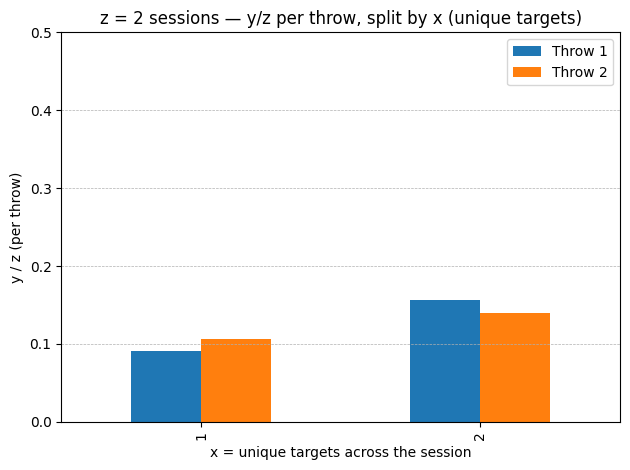

In [ ]:
# ============================================
# z = 2 sessions: y/z for first vs second throw,
# split by x = 1 and x = 2
# - Rebuilds sessions from *_events_with_phase1_tags_by_nearest_time.xlsx
# - x = UNIQUE 'who' across the whole session from paired rows at each throw time
# - y for a throw = 1 if any same-team row at that time encodes throw+hit
# - y/z for a throw (since z=2) = (hit rate for that throw) / 2
# ============================================

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Config ----------
ROOT = '/content/drive/MyDrive/Winrate predictions'
INHERIT_WINDOW = 1.2
EXCLUDE_THROW_ROW_FROM_X = True   # exclude the throw row itself from x (targets)
X_LABEL_FILTER = None             # e.g. ['got targeted'] to restrict; None = count anything

# ---------- helpers ----------
def _canon_text(s: str) -> str:
    return re.sub(r'[^a-z0-9_ ]', '', str(s).lower())

def _token(row) -> str:
    raw = str(row.get('definitionKey','') or '') or str(row.get('title','') or '')
    return _canon_text(raw)

def _is_throw_row(row) -> bool:
    t = _token(row).replace(' ', '')
    return 'throw' in t

def _is_throw_hit(row) -> bool:
    t = _token(row).replace(' ', '')
    return ('throwhit' in t) or (('throw' in t) and ('hit' in t))

def _label_passes_filter(row) -> bool:
    if X_LABEL_FILTER is None:
        return True
    tok = _token(row)
    return any(sub.lower() in tok for sub in X_LABEL_FILTER)

def _to_bool(x):
    if isinstance(x, bool): return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x): return x != 0
    s = str(x).strip().lower()
    return s in {'1','1.0','true','t','yes','y'}

# ---------- scan all event+tags files ----------
paths = sorted(glob.glob(os.path.join(ROOT, '**', '*_events_with_phase1_tags_by_nearest_time.xlsx'), recursive=True))
if not paths:
    raise FileNotFoundError("No '*_events_with_phase1_tags_by_nearest_time.xlsx' under ROOT.")

throw_rows = []  # one row per throw in z=2 sessions

for p in paths:
    ev = pd.read_excel(p)
    base = os.path.basename(p)

    need = ['time','team','who','is_throw','phase1_category']
    miss = [c for c in need if c not in ev.columns]
    if miss:
        print(f"[skip] {base}: missing {miss}")
        continue

    # normalize
    ev['time'] = pd.to_numeric(ev['time'], errors='coerce')
    ev = ev[ev['time'].notna()].copy()
    ev['team'] = pd.to_numeric(ev['team'], errors='coerce').fillna(0).astype(int)
    ev['who']  = ev['who'].astype(str).str.strip()
    ev['is_throw'] = ev['is_throw'].map(_to_bool)

    # only set_throw rows (starter or inherited)
    throws = (
        ev[(ev['is_throw']) & (ev['phase1_category'].astype(str) == 'set_throw')]
          .sort_values(['team','time'])
          .reset_index(drop=True)
    )
    if throws.empty:
        continue

    # sessions: consecutive same-team set_throws with gap <= INHERIT_WINDOW
    for team, g in throws.groupby('team'):
        g = g.sort_values('time').reset_index(drop=True)
        start_idx = 0
        for i in range(1, len(g)+1):
            if i == len(g) or (g.loc[i, 'time'] - g.loc[i-1, 'time']) > INHERIT_WINDOW:
                sess = g.iloc[start_idx:i].copy()
                start_idx = i

                # only z=2 sessions for this analysis
                if len(sess) != 2:
                    continue

                # Build the session's UNIQUE target set (x)
                targets_set = set()
                for _, r in sess.iterrows():
                    t = float(r['time'])
                    same_t = ev[ev['time'] == t].copy()

                    x_pool = same_t.copy()
                    if EXCLUDE_THROW_ROW_FROM_X:
                        x_pool = x_pool[~x_pool.apply(_is_throw_row, axis=1)]
                    if X_LABEL_FILTER is not None:
                        x_pool = x_pool[x_pool.apply(_label_passes_filter, axis=1)]

                    new_targets = set(x_pool['who'].astype(str).str.strip())
                    new_targets.discard('')
                    targets_set |= new_targets

                x_unique = int(len(targets_set))

                # Per-throw hit flags for the two throws
                sess_sorted = sess.sort_values('time').reset_index(drop=True)
                for j in range(2):
                    tr = sess_sorted.loc[j]
                    t = float(tr['time'])
                    throw_team = int(tr['team'])
                    same_team_t = ev[(ev['time'] == t) & (ev['team'] == throw_team)]
                    hit_flag = bool(any(same_team_t.apply(_is_throw_hit, axis=1)))

                    throw_rows.append({
                        'source_file': base,
                        'team': throw_team,
                        'session_start_time': float(sess_sorted.loc[0, 'time']),
                        'z_throws': 2,
                        'x_unique': x_unique,
                        'throw_index': j+1,  # 1 or 2
                        'hit_flag': int(hit_flag),
                    })

# ---------- aggregate (x in {1,2}) ----------
df = pd.DataFrame(throw_rows)
if df.empty:
    raise RuntimeError("No z=2 set-throw sessions found.")

df2 = df[df['x_unique'].isin([1, 2])].copy()
summary = (
    df2.groupby(['x_unique','throw_index'], as_index=False)
       .agg(
           n_throws=('hit_flag','size'),
           hits=('hit_flag','sum')
       )
)
summary['hit_rate_per_throw'] = np.where(summary['n_throws']>0, summary['hits']/summary['n_throws'], np.nan)
summary['y_over_z_for_this_throw'] = summary['hit_rate_per_throw'] / 2.0  # since z = 2

# pretty print
print("\nz=2 sessions — split by x and throw index")
print("(hit_rate_per_throw = hits / #throws; y_over_z_for_this_throw = hit_rate_per_throw / 2)")
print(summary.sort_values(['x_unique','throw_index']).to_string(index=False))

# ---------- grouped bar chart: y/z per throw, split by x ----------
# x-axis groups: x=1 and x=2; bars: throw 1 and throw 2
plot_df = summary.pivot(index='x_unique', columns='throw_index', values='y_over_z_for_this_throw').reindex([1,2])
plot_df = plot_df.rename(columns={1:'Throw 1', 2:'Throw 2'})

if not plot_df.empty:
    ax = plot_df.plot(kind='bar')
    ax.set_title('z = 2 sessions — y/z per throw, split by x (unique targets)')
    ax.set_xlabel('x = unique targets across the session')
    ax.set_ylabel('y / z (per throw)')
    ax.set_ylim(0, 0.5)  # with z=2, y/z per throw ∈ [0, 0.5]
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.legend(title='')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot after filtering to x ∈ {1,2}.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


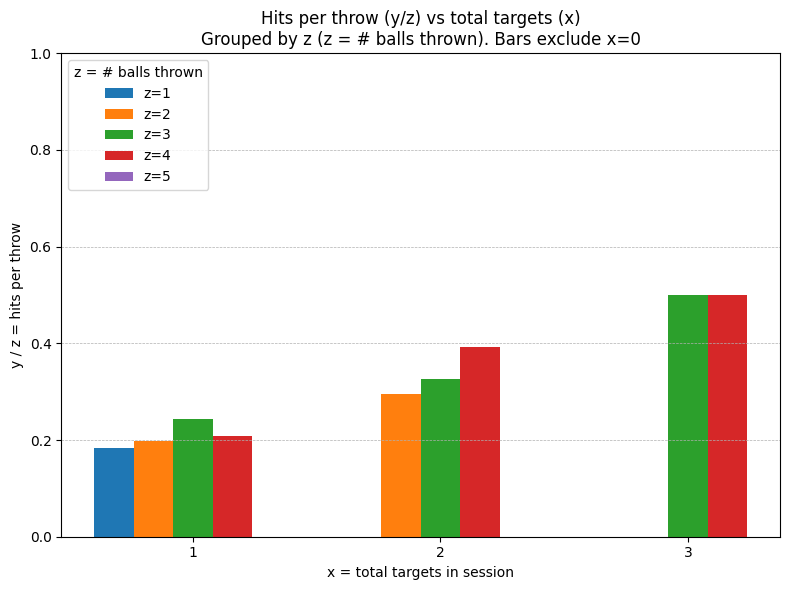


Summary by (z, x):
 z_throws  x_total_targets  n_sessions  total_y  total_z  rate_y_over_z_weighted  mean_rate_y_over_z_unweighted
        1                0         214       47      214                0.219626                       0.219626
        1                1        4678      858     4678                0.183412                       0.183412
        2                0          27       14       54                0.259259                       0.259259
        2                1         693      274     1386                0.197691                       0.197691
        2                2         218      129      436                0.295872                       0.295872
        3                0           3        1        9                0.111111                       0.111111
        3                1          66       48      198                0.242424                       0.242424
        3                2          49       48      147                0.326531    

In [ ]:
# ============================================
# Hits per throw (y/z) vs total targets (x)
# - One combined grouped BAR chart (different color per z)
# - EXCLUDES x=0 FROM THE GRAPH ONLY
# - Legend marks: z = # balls thrown
# - No 'n=' annotations on bars
# ============================================

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Paths / knobs --------
ROOT   = '/content/drive/MyDrive/Winrate predictions'
INFILE = os.path.join(ROOT, 'set_throw_session_success_by_xyz.xlsx')  # produced earlier
SHEET  = 'sessions_raw'

# plot the most common Z values (by session count). Set to 0/None to include ALL
N_Z_TO_PLOT = 6

# reduce noise by requiring at least this many sessions in a (z, x) cell
MIN_SESSIONS_PER_POINT = 5

# -------- Load per-session data --------
df = pd.read_excel(INFILE, sheet_name=SHEET)

# Clean types
df['x_total_targets'] = pd.to_numeric(df['x_total_targets'], errors='coerce').fillna(0).astype(int)
df['y_targets_hit']   = pd.to_numeric(df['y_targets_hit'], errors='coerce').fillna(0).astype(int)
df['z_throws']        = pd.to_numeric(df['z_throws'], errors='coerce').fillna(0).astype(int)

# Per-session rate
df['rate_y_over_z_session'] = np.where(df['z_throws'] > 0, df['y_targets_hit'] / df['z_throws'], np.nan)

# -------- Aggregate by (z, x) --------
# Weighted-by-throws conversion at each (z, x): sum(y) / sum(z)
zx_weighted = (
    df.groupby(['z_throws', 'x_total_targets'], as_index=False)
      .agg(
          n_sessions=('x_total_targets', 'size'),
          total_y=('y_targets_hit', 'sum'),
          total_z=('z_throws', 'sum'),
      )
)
zx_weighted['rate_y_over_z_weighted'] = np.where(
    zx_weighted['total_z'] > 0, zx_weighted['total_y'] / zx_weighted['total_z'], np.nan
)

# Unweighted (mean of per-session rates) for reference
zx_unweighted = (
    df.groupby(['z_throws', 'x_total_targets'], as_index=False)
      .agg(mean_rate_y_over_z_unweighted=('rate_y_over_z_session', 'mean'))
)

# Merge both views
zx = zx_weighted.merge(zx_unweighted, on=['z_throws','x_total_targets'], how='left')

# -------- Choose which z to visualize (top by session count) --------
z_order = (
    zx.groupby('z_throws')['n_sessions']
      .sum()
      .sort_values(ascending=False)
      .index
      .tolist()
)
z_to_plot = z_order[:N_Z_TO_PLOT] if N_Z_TO_PLOT else z_order

# -------- Build grouped bar data (filter x=0 ONLY for plotting) --------
plot_data = zx[(zx['x_total_targets'] > 0) & (zx['n_sessions'] >= MIN_SESSIONS_PER_POINT)]
if plot_data.empty:
    print("No (z, x) cells meet the plotting criteria after filtering; try lowering MIN_SESSIONS_PER_POINT.")
else:
    # Use only the selected z's
    plot_data = plot_data[plot_data['z_throws'].isin(z_to_plot)]

    # Union of x values across selected z's (sorted)
    x_vals = sorted(plot_data['x_total_targets'].unique())
    x_index = np.arange(len(x_vals), dtype=float)

    # Bar width based on how many z series we show
    n_series = max(1, len(z_to_plot))
    bar_width = 0.8 / n_series

    plt.figure(figsize=(max(8, 1.2*len(x_vals)), 6))

    # For each z, align values to union x and plot bars side-by-side
    for i, z in enumerate(z_to_plot):
        sub = plot_data[plot_data['z_throws'] == z].set_index('x_total_targets')
        heights = [sub.loc[x, 'rate_y_over_z_weighted'] if (x in sub.index) else np.nan for x in x_vals]
        positions = x_index + (i - (n_series-1)/2) * bar_width
        plt.bar(positions, heights, width=bar_width, label=f'z={z}')

    plt.title('Hits per throw (y/z) vs total targets (x)\nGrouped by z (z = # balls thrown). Bars exclude x=0')
    plt.xlabel('x = total targets in session')
    plt.ylabel('y / z = hits per throw')
    plt.xticks(x_index, x_vals)
    plt.ylim(0, 1)  # proportion
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.legend(title='z = # balls thrown')
    plt.tight_layout()
    plt.show()

# -------- Nicely sorted table for inspection/export --------
zx_sorted = zx.sort_values(['z_throws','x_total_targets']).reset_index(drop=True)
print("\nSummary by (z, x):")
display_cols = [
    'z_throws','x_total_targets','n_sessions',
    'total_y','total_z',
    'rate_y_over_z_weighted','mean_rate_y_over_z_unweighted'
]
print(zx_sorted[display_cols].to_string(index=False))




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ========= COUNTER-RUSH: success ~ avg distance, alignment rate, and time since prior set-throw =========
# Requires: ROOT, prepare_coords, coords_at_nearest_time, is_throw_hit_row,
#           load_game_paths, normalize_teams, T0_ZONE, T1_ZONE  (from your earlier cell)

import os, glob
import numpy as np
import pandas as pd


ROOT = '/content/drive/MyDrive/Winrate predictions'   # folder with "<reviewId>_data_files" subfolders
OUTFILE = os.path.join(ROOT, 'counter_rush_success_vs_avgdist_alignrate_and_prior_set_time.xlsx')

# Midline (adapts if you change zones)
MIDDLE_Y = 900  # usually 900.0

# Labels considered "counter rush"
INCLUDE_BACKLINE = False    # True => also include 'backline_counter'
DIST_BAND_MAX = 700.0       # band for avg distance and alignment computation

# ---------- helpers ----------
def was_team_hit_at_same_time(events_df, team, t):
    """True only if a same-team 'throw hit' event shares EXACT time t."""
    if events_df is None or len(events_df) == 0 or pd.isna(t):
        return False
    ev = events_df.copy()
    ev['time'] = pd.to_numeric(ev['time'], errors='coerce')
    ev = ev.dropna(subset=['time','team'])
    is_hit = ev.apply(lambda r: is_throw_hit_row(r.get('title',''), r.get('definitionKey','')), axis=1)
    hits = ev.loc[is_hit & (ev['team'] == int(team))]
    return bool((hits['time'] == t).any())

def distances_and_alignment_for_team_at_time(coords_df, team, t):
    """
    Returns:
      frontmost_abs_dist: min |y-mid|
      mean_abs_dist_0_700: mean |y-mid| for teammates with |y-mid| <= 700 (NaN if none)
      n_in_band: count used in mean_abs_dist_0_700
      alignment_std_y_0_700: std of raw y for teammates with |y-mid| <= 700
                              (0 if exactly one; NaN if none)
    """
    snap = coords_at_nearest_time(coords_df, t)
    if snap is None or snap.empty:
        return np.nan, np.nan, 0, np.nan
    snap_team = snap[snap['team'] == int(team)].copy()
    if snap_team.empty:
        return np.nan, np.nan, 0, np.nan

    absd = np.abs(snap_team['y'] - MIDDLE_Y)
    frontmost = float(absd.min())

    in_band_mask = absd <= DIST_BAND_MAX
    in_band_absd = absd[in_band_mask]
    in_band_y = snap_team.loc[in_band_mask, 'y']

    if in_band_absd.empty:
        mean_band = np.nan
        n_band = 0
        align_std = np.nan
    else:
        mean_band = float(in_band_absd.mean())
        n_band = int(in_band_absd.shape[0])
        align_std = 0.0 if len(in_band_y) == 1 else float(in_band_y.std(ddof=0))

    return frontmost, mean_band, n_band, align_std

def compute_set_numbers(events_df):
    """Return events_df with a 'set_no' computed from Won/Lost Round boundaries."""
    if events_df is None or len(events_df) == 0:
        return None
    ev = events_df.copy()
    ev['time'] = pd.to_numeric(ev['time'], errors='coerce')
    ev = ev.dropna(subset=['time'])
    ev['title'] = ev.get('title','').astype(str)
    ev['definitionKey'] = ev.get('definitionKey','').astype(str)
    # normalize teams to {0,1}
    ev['team'] = normalize_teams(ev.get('team', np.nan))
    boundary = ev['title'].str.strip().str.lower().isin(['won round','lost round']) | \
               ev['definitionKey'].str.strip().str.lower().isin(['won round','lost round'])
    ev = ev.sort_values('time')
    ev['set_no'] = boundary.cumsum().shift(fill_value=0) + 1
    return ev

def point_biserial_corr(binary_series, continuous_series):
    """Point-biserial (Pearson) correlation between 0/1 and continuous."""
    s = pd.DataFrame({'b': binary_series.astype(float), 'x': continuous_series})
    s = s.dropna()
    if s.empty or s['b'].nunique() < 2:
        return np.nan
    b = s['b'].to_numpy()
    x = s['x'].to_numpy()
    if np.std(x) == 0:
        return np.nan
    return float(np.corrcoef(b, x)[0, 1])

# ---------- main aggregation ----------
analysis_rows = []

game_folders = sorted(glob.glob(os.path.join(ROOT, '*_data_files')))
for gf in game_folders:
    # Files from your earlier pipeline
    phase1_paths = sorted(glob.glob(os.path.join(gf, '*_phase1_categorized_by_nearest_time.xlsx')))
    events_paths = sorted(glob.glob(os.path.join(gf, '*_events_with_phase1_tags_by_nearest_time.xlsx')))
    if not phase1_paths:
        print(f"[skip] No phase1 output in {gf}")
        continue

    phase1_path = phase1_paths[0]
    events_path = events_paths[0] if events_paths else None
    review_id = os.path.basename(phase1_path).replace('_phase1_categorized_by_nearest_time.xlsx','')

    try:
        phase1_df = pd.read_excel(phase1_path)
    except Exception as e:
        print(f"[skip] Could not read {phase1_path}: {e}")
        continue

    events_df = None
    if events_path:
        try:
            events_df = pd.read_excel(events_path)
        except Exception as e:
            print(f"[warn] Could not read events+tags for {review_id}: {e}")

    # coords
    _, coord_path = load_game_paths(gf)
    if coord_path is None:
        print(f"[skip] No coords in {gf}")
        continue
    try:
        coords_df = prepare_coords(pd.read_excel(coord_path))
    except Exception as e:
        print(f"[skip] Bad coords for {review_id}: {e}")
        continue

    # Compute set_no on events and map to throws (phase1_df has only throws)
    ev_with_set = compute_set_numbers(events_df)
    if ev_with_set is None:
        print(f"[warn] No events to compute set numbers in {review_id}")
        continue

    # throws_with_set: merge phase1 throws with set_no from events via (time,team)
    throws_with_set = phase1_df.copy()
    for col in ['time','team']:
        throws_with_set[col] = pd.to_numeric(throws_with_set[col], errors='coerce')
    throws_with_set['team'] = throws_with_set['team'].fillna(0).astype(int)

    ev_keys = ev_with_set[['time','team','set_no']].copy()
    # merge might duplicate if multiple events share the same (time,team); keep first match
    throws_with_set = throws_with_set.merge(ev_keys, on=['time','team'], how='left')

    # Candidate "set throw" rows from throws_with_set (opponent's phase1 set throw)
    set_throw_rows = throws_with_set[throws_with_set['phase1_category'] == 'set_throw'][['set_no','team','time']].dropna()

    # Focus on counter rush (optionally include backline_counter)
    cats = ['counter_rush'] + (['backline_counter'] if INCLUDE_BACKLINE else [])
    cr = throws_with_set[throws_with_set['phase1_category'].isin(cats)].dropna(subset=['time','team']).sort_values('time')
    if cr.empty:
        continue

    for _, r in cr.iterrows():
        t = float(r['time']); team = int(r['team'])
        s = r.get('set_no', np.nan)
        s = int(s) if pd.notna(s) else None

        hit_exact = was_team_hit_at_same_time(events_df, team, t)
        frontmost, mean_band, n_band, align_std = distances_and_alignment_for_team_at_time(coords_df, team, t)
        align_rate = np.nan if pd.isna(align_std) else float(1.0 / (1.0 + align_std))

        # Time since the prior set throw by the OPPOSING team within the SAME set
        dt_prior_set = np.nan
        if s is not None:
            opp = 1 - team
            candidates = set_throw_rows[(set_throw_rows['set_no'] == s) &
                                        (set_throw_rows['team'] == opp) &
                                        (set_throw_rows['time'] < t)]
            if not candidates.empty:
                last_set_t = float(candidates['time'].max())
                dt_prior_set = t - last_set_t

        analysis_rows.append({
            'reviewId': review_id,
            'time': t,
            'team': team,
            'set_no': s,
            'phase1_category': r.get('phase1_category',''),
            'after_switch': bool(r.get('after_switch', False)),
            'hit_at_same_time': bool(hit_exact),
            'frontmost_abs_dist': frontmost,
            'mean_abs_dist_0_700': mean_band,
            'n_in_band_0_700': n_band,
            'alignment_std_y_0_700': align_std,
            'alignment_rate_0_700': align_rate,
            'dt_prior_set_throw': dt_prior_set
        })

# ---------- aggregate, correlate, bin, save ----------
if not analysis_rows:
    print("No counter-rush rows found across games.")
else:
    res_df = pd.DataFrame(analysis_rows)

    # Correlations (point-biserial) — positive r means success increases with the metric
    corr_meanband   = point_biserial_corr(res_df['hit_at_same_time'].astype(int), res_df['mean_abs_dist_0_700'])
    corr_align_rate = point_biserial_corr(res_df['hit_at_same_time'].astype(int), res_df['alignment_rate_0_700'])
    corr_dt_prior   = point_biserial_corr(res_df['hit_at_same_time'].astype(int), res_df['dt_prior_set_throw'])

    # ----- Bins: mean distance in 0–700 -----
    mb_mask = res_df['n_in_band_0_700'] > 0
    mean_bins = [0, 100, 200, 300, 400, 500, 600, 700]
    mean_labels = ["0-100","100-200","200-300","300-400","400-500","500-600","600-700"]
    res_df.loc[mb_mask, 'mean_band_bin'] = pd.cut(
        res_df.loc[mb_mask, 'mean_abs_dist_0_700'],
        bins=mean_bins, labels=mean_labels, right=False, include_lowest=True
    )
    by_meanband = (
        res_df.loc[mb_mask]
              .groupby('mean_band_bin', dropna=False, observed=False)
              .agg(n=('hit_at_same_time','size'),
                   success_rate=('hit_at_same_time','mean'))
              .reset_index()
              .sort_values('mean_band_bin')
    )

    # ----- Bins: alignment RATE (use deciles for even spread) -----
    ar_mask = res_df['alignment_rate_0_700'].notna()
    # deciles (duplicates='drop' handles ties)
    try:
        res_df.loc[ar_mask, 'alignment_rate_decile'] = pd.qcut(
            res_df.loc[ar_mask, 'alignment_rate_0_700'],
            q=10, duplicates='drop'
        )
    except Exception:
        # fallback if distribution is too discrete
        res_df.loc[ar_mask, 'alignment_rate_decile'] = pd.qcut(
            res_df.loc[ar_mask, 'alignment_rate_0_700'].rank(method='first'),
            q=10, duplicates='drop'
        )
    by_alignrate = (
        res_df.loc[ar_mask]
              .groupby('alignment_rate_decile', dropna=False, observed=False)
              .agg(n=('hit_at_same_time','size'),
                   success_rate=('hit_at_same_time','mean'))
              .reset_index()
              .sort_values('alignment_rate_decile')
    )

    # ----- Bins: time since prior set-throw (opponent) -----
    dt_mask = res_df['dt_prior_set_throw'].notna()
    # Choose bins around your tactical windows (2.5s, 3.5s) with broader tails
    dt_bins = [0, 1.0, 2.0, 2.5, 3.5, 5.0, 8.0, 12.0, 20.0, np.inf]
    dt_labels = ["0-1","1-2","2-2.5","2.5-3.5","3.5-5","5-8","8-12","12-20","20+"]
    res_df.loc[dt_mask, 'dt_prior_set_bin'] = pd.cut(
        res_df.loc[dt_mask, 'dt_prior_set_throw'],
        bins=dt_bins, labels=dt_labels, right=False, include_lowest=True
    )
    by_dt_prior = (
        res_df.loc[dt_mask]
              .groupby('dt_prior_set_bin', dropna=False, observed=False)
              .agg(n=('hit_at_same_time','size'),
                   success_rate=('hit_at_same_time','mean'))
              .reset_index()
              .sort_values('dt_prior_set_bin')
    )

    # Correlation summary
    corr_summary = pd.DataFrame([
        {'metric': 'mean_abs_dist_0_700',   'point_biserial_r': corr_meanband},
        {'metric': 'alignment_rate_0_700',  'point_biserial_r': corr_align_rate},
        {'metric': 'dt_prior_set_throw',    'point_biserial_r': corr_dt_prior},
    ])

    # Save to Excel (openpyxl)
    with pd.ExcelWriter(OUTFILE, engine='openpyxl') as w:
        res_df.to_excel(w, index=False, sheet_name='per_throw')
        by_meanband.to_excel(w, index=False, sheet_name='by_mean_distance_bins')
        by_alignrate.to_excel(w, index=False, sheet_name='by_alignment_rate_deciles')
        by_dt_prior.to_excel(w, index=False, sheet_name='by_dt_prior_set_bins')
        corr_summary.to_excel(w, index=False, sheet_name='correlation_summary')

    print(f"[analysis saved] {OUTFILE}")
    print(corr_summary)
    print("\nMean distance bins (sample):")
    print(by_meanband.head(10))
    print("\nAlignment rate deciles (sample):")
    print(by_alignrate.head(10))
    print("\nDelta-time from prior set-throw bins (sample):")
    print(by_dt_prior.head(10))


[skip] No phase1 output in /content/drive/MyDrive/Winrate predictions/f2195ce9-4398-4e62-b48a-607989531719_data_files
[analysis saved] /content/drive/MyDrive/Winrate predictions/counter_rush_success_vs_avgdist_alignrate_and_prior_set_time.xlsx
                 metric  point_biserial_r
0   mean_abs_dist_0_700         -0.007965
1  alignment_rate_0_700         -0.030327
2    dt_prior_set_throw          0.027038

Mean distance bins (sample):
  mean_band_bin    n  success_rate
0         0-100   12      0.166667
1       100-200   62      0.258065
2       200-300  136      0.213235
3       300-400  289      0.221453
4       400-500  408      0.208333
5       500-600  450      0.211111
6       600-700  174      0.241379

Alignment rate deciles (sample):
  alignment_rate_decile    n  success_rate
0    (0.00208, 0.00702]  154      0.233766
1    (0.00702, 0.00898]  153      0.281046
2     (0.00898, 0.0114]  153      0.183007
3      (0.0114, 0.0136]  153      0.222222
4      (0.0136, 0.0171]  153 

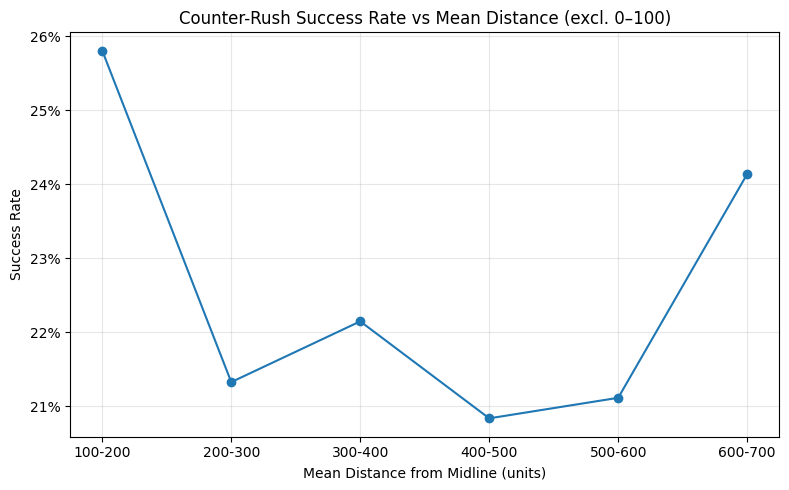

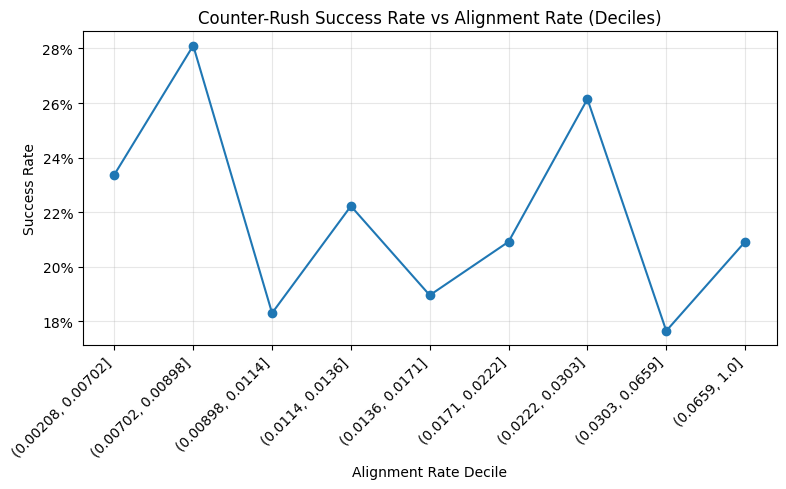

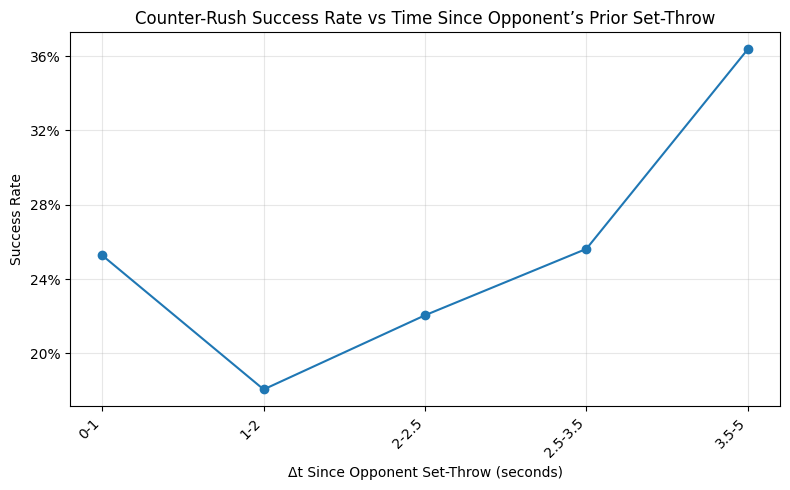

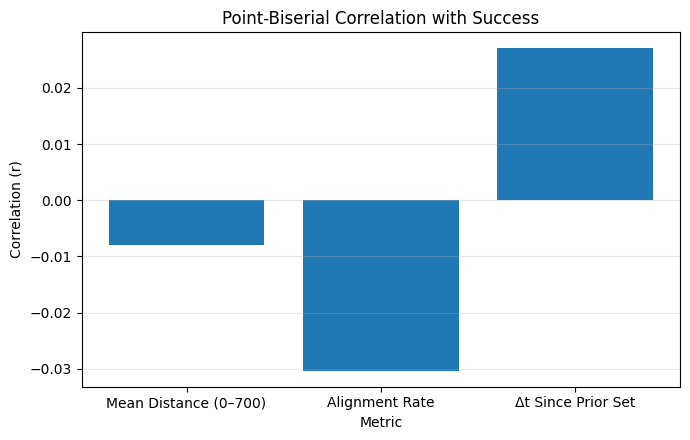

[figures saved] /content/drive/MyDrive/Winrate predictions/figures_counter_rush


In [ ]:
# === NICE GRAPHS (append to the end of your script) ===
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator

OUTDIR = os.path.join(ROOT, "figures_counter_rush")
os.makedirs(OUTDIR, exist_ok=True)

# --- Helper: percent y-axis ---
def set_percent_axis(ax):
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

# 1) Success rate vs. mean distance bin (EXCLUDING 0–100)
meanband_plot = by_meanband.copy()
if 'mean_band_bin' in meanband_plot.columns:
    meanband_plot['mean_band_bin'] = meanband_plot['mean_band_bin'].astype(str)
    meanband_plot = meanband_plot[meanband_plot['mean_band_bin'] != "0-100"]
    # Keep the natural bin order
    order = ["100-200","200-300","300-400","400-500","500-600","600-700"]
    meanband_plot['mean_band_bin'] = pd.Categorical(meanband_plot['mean_band_bin'], categories=order, ordered=True)
    meanband_plot = meanband_plot.sort_values('mean_band_bin')

plt.figure(figsize=(8,5))
plt.plot(meanband_plot['mean_band_bin'].astype(str), meanband_plot['success_rate'], marker='o')
plt.title("Counter-Rush Success Rate vs Mean Distance (excl. 0–100)")
plt.xlabel("Mean Distance from Midline (units)")
plt.ylabel("Success Rate")
plt.grid(True, alpha=0.3)
set_percent_axis(plt.gca())
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "success_vs_mean_distance.png"), dpi=150)
plt.show()

# 2) Success rate vs. alignment rate (deciles)
align_plot = by_alignrate.copy()
if 'alignment_rate_decile' in align_plot.columns:
    # Ensure clean string labels in decile order
    align_plot['alignment_rate_decile_str'] = align_plot['alignment_rate_decile'].astype(str)

plt.figure(figsize=(8,5))
plt.plot(align_plot['alignment_rate_decile_str'], align_plot['success_rate'], marker='o')
plt.title("Counter-Rush Success Rate vs Alignment Rate (Deciles)")
plt.xlabel("Alignment Rate Decile")
plt.ylabel("Success Rate")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
set_percent_axis(plt.gca())
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "success_vs_alignment_rate_deciles.png"), dpi=150)
plt.show()

# 3) Success rate vs. time since prior set-throw
dt_plot = by_dt_prior.copy()
if 'dt_prior_set_bin' in dt_plot.columns:
    dt_plot['dt_prior_set_bin'] = dt_plot['dt_prior_set_bin'].astype(str)
    # Keep your label order if present
    dt_order = ["0-1","1-2","2-2.5","2.5-3.5","3.5-5","5-8","8-12","12-20","20+"]
    dt_plot['dt_prior_set_bin'] = pd.Categorical(dt_plot['dt_prior_set_bin'], categories=dt_order, ordered=True)
    dt_plot = dt_plot.sort_values('dt_prior_set_bin')

plt.figure(figsize=(8,5))
plt.plot(dt_plot['dt_prior_set_bin'].astype(str), dt_plot['success_rate'], marker='o')
plt.title("Counter-Rush Success Rate vs Time Since Opponent’s Prior Set-Throw")
plt.xlabel("Δt Since Opponent Set-Throw (seconds)")
plt.ylabel("Success Rate")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
set_percent_axis(plt.gca())
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "success_vs_dt_prior_set.png"), dpi=150)
plt.show()

# 4) Correlation summary bar chart
corr_plot = corr_summary.copy()
corr_plot['metric_pretty'] = corr_plot['metric'].replace({
    'mean_abs_dist_0_700': 'Mean Distance (0–700)',
    'alignment_rate_0_700': 'Alignment Rate',
    'dt_prior_set_throw':   'Δt Since Prior Set'
})

plt.figure(figsize=(7,4.5))
plt.bar(corr_plot['metric_pretty'], corr_plot['point_biserial_r'])
plt.title("Point-Biserial Correlation with Success")
plt.xlabel("Metric")
plt.ylabel("Correlation (r)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "correlation_summary.png"), dpi=150)
plt.show()

print(f"[figures saved] {OUTDIR}")


In [ ]:
# ============================================
# Per-throw success from EVENTS ONLY (same-row punish/followup, robust booleans)
# ============================================

from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
import numpy as np
import pandas as pd

# -------- CONFIG --------
ROOT = '/content/drive/MyDrive/Winrate predictions'  # change if needed
OUTFILE = os.path.join(ROOT, 'throw_success_with_pf_from_events__fixed.xlsx')
TIME_DECIMALS = 3  # time bucketing for pairing labels

# Debug printing controls:
DEBUG_EACH_ROW = False      # True = print one debug line for every processed throw row
DEBUG_MAX_PER_FILE = 30     # safety cap if DEBUG_EACH_ROW=True (per file)
DEBUG_PRINT_TRUE_ONLY = True  # if True, always print rows where punish/followup is True (ignores caps)

# -------- Helpers --------
def _norm_hdr(s: str) -> str:
    """Lowercase header and remove non-alnum to be robust to spaces/underscores."""
    return re.sub(r'[^a-z0-9]', '', str(s).lower())

def _find_flag_cols(df: pd.DataFrame):
    """Return lists of columns that look like punish/followup flags."""
    pun_cols = [c for c in df.columns if _norm_hdr(c).startswith('ispunish')]
    fol_cols = [c for c in df.columns if _norm_hdr(c).startswith('isfollowup')]
    return pun_cols, fol_cols

TRUE_STRS  = {'1', '1.0', 'true', 't', 'yes', 'y'}
FALSE_STRS = {'0', '0.0', 'false', 'f', 'no', 'n', ''}

def _coerce_bool_scalar(x) -> bool:
    """Interpret numbers, strings, and bools reliably."""
    if isinstance(x, bool):
        return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x):
        return x != 0
    s = str(x).strip().lower()
    if s in TRUE_STRS:  return True
    if s in FALSE_STRS: return False
    try:
        return float(s) != 0.0
    except Exception:
        return False

def _row_any(row: pd.Series, cols) -> bool:
    if not cols:
        return False
    return any(_coerce_bool_scalar(row.get(c, False)) for c in cols)

def _mk_label_token(row) -> str:
    """Prefer definitionKey; fall back to title; normalize to a compact token."""
    raw = (str(row.get('definitionKey','') or '')).strip()
    if not raw:
        raw = (str(row.get('title','') or '')).strip()
    s = raw.lower().replace('-', ' ').replace('/', ' ')
    s = re.sub(r'\s+', '_', s.strip())
    s = re.sub(r'[^a-z0-9_]', '', s)
    return s or '(empty)'

def _canon(s: str) -> str:
    return re.sub(r'[\s_]+', '', str(s).lower())

def success_from_labels(labels_concat: str):
    """
    Hit if any paired label conveys 'throw'+'hit'.
    Miss if any paired label conveys 'throw'+'miss' OR 'throw'+'ontarget'.
    If both, HIT wins. Else unknown (np.nan).
    """
    if not isinstance(labels_concat, str) or not labels_concat.strip():
        return np.nan
    hit = miss = False
    for lb in [x.strip() for x in labels_concat.split(',') if x.strip()]:
        t = _canon(lb)
        if 'throw' not in t:
            continue
        if 'hit' in t:
            hit = True
        if ('miss' in t) or ('ontarget' in t):
            miss = True
    if hit:  return True
    if miss: return False
    return np.nan

def _debug_print_row(base, r, pun_cols, fol_cols, is_pun, is_fol, counter):
    title = str(r.get('title',''))[:20].replace('\n',' ')
    dkey  = str(r.get('definitionKey',''))[:20].replace('\n',' ')
    pun_vals = [str(r.get(c, 'NA')) for c in pun_cols] or ['NA']
    fol_vals = [str(r.get(c, 'NA')) for c in fol_cols] or ['NA']
    print(f"[{base}] t={r.get('time')} team={r.get('team')} "
          f"title='{title}' def='{dkey}' | "
          f"pun_cols={pun_cols} pun_vals={pun_vals} -> is_punish={is_pun}  ||  "
          f"fol_cols={fol_cols} fol_vals={fol_vals} -> is_followup={is_fol}  "
          f"(row #{counter})")

# -------- Build per-throw across all event files --------
paths = glob.glob(os.path.join(ROOT, '**', '*_events_with_phase1_tags_by_nearest_time.xlsx'), recursive=True)
if not paths:
    raise FileNotFoundError("No '*_events_with_phase1_tags_by_nearest_time.xlsx' under ROOT.")

rows = []
debug_rows = []

for p in sorted(paths):
    base = os.path.basename(p)
    try:
        df = pd.read_excel(p)
    except Exception as e:
        print(f"[skip] {base}: read error: {e}")
        continue

    if 'time' not in df.columns:
        print(f"[skip] {base}: no 'time' column")
        continue

    # Basic normalization
    df['time']  = pd.to_numeric(df['time'], errors='coerce')
    df = df[df['time'].notna()].copy()
    df['time_key'] = df['time'].round(TIME_DECIMALS)
    df['title']        = df.get('title','').astype(str)
    df['definitionKey']= df.get('definitionKey','').astype(str)

    # Throw detector
    if 'is_throw' in df.columns:
        df['is_throw'] = df['is_throw'].astype(str).str.strip().str.lower().isin(['true','1','t','yes','y'])
    else:
        df['is_throw'] = df[['title','definitionKey']].apply(
            lambda r: 'throw' in (r['title'].lower() + ' ' + r['definitionKey'].lower()),
            axis=1
        )

    # Per-time labels (to pair outcomes)
    df['label_key'] = df.apply(_mk_label_token, axis=1)
    labels_by_time = {float(tk): sorted(set(g['label_key'].tolist()))
                      for tk, g in df.groupby('time_key')}

    # SAME-ROW flags (robust to headers and data types)
    pun_cols, fol_cols = _find_flag_cols(df)
    debug_rows.append({'file': base, 'punish_cols_found': ', '.join(pun_cols) or '(none)',
                       'followup_cols_found': ', '.join(fol_cols) or '(none)'})

    printed = 0
    true_prints = 0

    # Emit one record per throw row
    for idx, r in df[df['is_throw']].iterrows():
        tk = float(r['time_key'])
        labels = labels_by_time.get(tk, [])

        is_pun   = _row_any(r, pun_cols)
        is_fol   = _row_any(r, fol_cols)

        # Optional debug prints
        should_print = False
        if DEBUG_EACH_ROW and printed < DEBUG_MAX_PER_FILE:
            should_print = True
            printed += 1
        if DEBUG_PRINT_TRUE_ONLY and (is_pun or is_fol):
            should_print = True
            true_prints += 1
        if should_print:
            _debug_print_row(base, r, pun_cols, fol_cols, is_pun, is_fol, idx)

        rows.append({
            'source_file': base,
            'time': float(r['time']),
            'time_key': tk,
            'team': pd.to_numeric(r.get('team', np.nan), errors='coerce'),
            'phase1_category': (str(r.get('phase1_category','(unlabeled)'))
                                if pd.notna(r.get('phase1_category', np.nan)) else '(unlabeled)'),
            'labels_concat': ','.join(labels),
            'is_punish': bool(is_pun),
            'is_followup': bool(is_fol),
        })

    print(f"[{base}] throws={len(df[df['is_throw']])}  punish_true={int(sum(_row_any(row, pun_cols) for _, row in df[df['is_throw']].iterrows()))}  "
          f"followup_true={int(sum(_row_any(row, fol_cols) for _, row in df[df['is_throw']].iterrows()))}  "
          f"(printed {printed} rows + {true_prints} true-flag rows)")

# ---- Assemble & summarize ----
throws = pd.DataFrame(rows)
if throws.empty:
    raise RuntimeError("No throws collected. Check is_throw and file structure.")

# Success flag from paired labels
throws['success_flag'] = throws['labels_concat'].map(success_from_labels)

# Success by phase1 throw type
success_by_type = (
    throws.groupby('phase1_category', dropna=False)
          .agg(n_total=('labels_concat','size'),
               n_scored=('success_flag', lambda s: s.notna().sum()),
               hits=('success_flag', lambda s: s.fillna(False).sum()))
          .reset_index()
)
success_by_type['success_rate'] = success_by_type.apply(
    lambda r: (r['hits'] / r['n_scored']) if r['n_scored'] > 0 else np.nan, axis=1
)

# Success by "category" (phase1 types + independent 'punish' + 'followup')
cat_rows = []
for _, r in throws.iterrows():
    cats = [r['phase1_category']]
    if r['is_punish']:   cats.append('punish')
    if r['is_followup']: cats.append('followup')
    for c in cats:
        cat_rows.append({'category': c, 'success_flag': r['success_flag']})
success_by_category = (
    pd.DataFrame(cat_rows)
      .groupby('category', dropna=False)
      .agg(n_total=('success_flag','size'),
           n_scored=('success_flag', lambda s: s.notna().sum()),
           hits=('success_flag', lambda s: s.fillna(False).sum()))
      .reset_index()
)
success_by_category['success_rate'] = success_by_category.apply(
    lambda r: (r['hits']/r['n_scored']) if r['n_scored']>0 else np.nan, axis=1
)

print("punish TRUE total:", int(throws['is_punish'].sum()),
      "| followup TRUE total:", int(throws['is_followup'].sum()))

# ---- Save ----
with pd.ExcelWriter(OUTFILE, engine='openpyxl') as w:
    throws[['source_file','time','time_key','team','phase1_category',
            'labels_concat','success_flag','is_punish','is_followup']].to_excel(
        w, index=False, sheet_name='per_throw_with_success'
    )
    success_by_type.to_excel(w, index=False, sheet_name='success_by_type')
    success_by_category.to_excel(w, index=False, sheet_name='success_by_category')
    pd.DataFrame(debug_rows).to_excel(w, index=False, sheet_name='__debug_flag_columns')

print("Saved:", OUTFILE)


Streaming output truncated to the last 5000 lines.
[48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time.xlsx] t=1290.632144 team=1 title='Throw Hit' def='throw_hit' | pun_cols=['is_punish'] pun_vals=['1.0'] -> is_punish=True  ||  fol_cols=['is_followup'] fol_vals=['0.0'] -> is_followup=False  (row #498)
[48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time.xlsx] t=1291.064119 team=0 title='Throw Miss' def='throw_miss' | pun_cols=['is_punish'] pun_vals=['1.0'] -> is_punish=True  ||  fol_cols=['is_followup'] fol_vals=['0.0'] -> is_followup=False  (row #500)
[48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time.xlsx] t=1307.34469 team=1 title='Throw Miss' def='throw_miss' | pun_cols=['is_punish'] pun_vals=['0.0'] -> is_punish=False  ||  fol_cols=['is_followup'] fol_vals=['1.0'] -> is_followup=True  (row #512)
[48335c8f-2857-4c43-b197-f73f508b4f0d_events_with_phase1_tags_by_nearest_time.xlsx] t=1313.9925 team=1 title=

/tmp/ipython-input-2021115040.py:197: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hits=('success_flag', lambda s: s.fillna(False).sum()))
/tmp/ipython-input-2021115040.py:217: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hits=('success_flag', lambda s: s.fillna(False).sum()))


punish TRUE total: 4974 | followup TRUE total: 1642
Saved: /content/drive/MyDrive/Winrate predictions/throw_success_with_pf_from_events__fixed.xlsx


In [ ]:
# =======================
# Success by type + punish/followup categories
# (reads the output from the previous block) — SORTED BY SUCCESS RATE DESC
# =======================

from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import pandas as pd

# --- Paths ---
ROOT = '/content/drive/MyDrive/Winrate predictions'
INFILE  = os.path.join(ROOT, 'throw_success_with_pf_from_events__fixed.xlsx')  # <-- read prior output
OUTFILE = os.path.join(ROOT, 'throw_type_success_with_pf_categories.xlsx')

# --- Load per-throw table ---
throws = pd.read_excel(INFILE, sheet_name='per_throw_with_success')

# Robust bool coercion
TRUE_STRS  = {'1','1.0','true','t','yes','y'}
FALSE_STRS = {'0','0.0','false','f','no','n',''}

def _to_bool(x):
    if isinstance(x, bool):
        return x
    if isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x):
        return x != 0
    s = str(x).strip().lower()
    if s in TRUE_STRS:  return True
    if s in FALSE_STRS: return False
    try:
        return float(s) != 0.0
    except Exception:
        return False

# Ensure expected columns (and clean)
for col in ['phase1_category', 'labels_concat']:
    if col not in throws.columns:
        raise KeyError(f"Missing column '{col}' in {INFILE} :: per_throw_with_success")

throws['phase1_category'] = throws['phase1_category'].astype(object)
throws.loc[throws['phase1_category'].isna(), 'phase1_category'] = '(unlabeled)'

# Guarantees: is_punish / is_followup present and boolean
throws['is_punish']   = throws.get('is_punish', False).map(_to_bool)
throws['is_followup'] = throws.get('is_followup', False).map(_to_bool)

# Success flag (use if present; else derive from labels)
def _canon(s: str) -> str:
    return re.sub(r'[\s_]+', '', str(s).lower())

def classify_success(labels_concat: str):
    if not isinstance(labels_concat, str) or labels_concat.strip() == '':
        return np.nan
    seen_hit = seen_miss = False
    for lb in [x.strip() for x in labels_concat.split(',') if x.strip()]:
        t = _canon(lb)
        if 'throw' not in t:
            continue
        if 'hit' in t:
            seen_hit = True
        if ('miss' in t) or ('ontarget' in t):
            seen_miss = True
    if seen_hit:  return True
    if seen_miss: return False
    return np.nan

if 'success_flag' not in throws.columns:
    throws['success_flag'] = throws['labels_concat'].map(classify_success)

# --- Per-type success summary ---
success_by_type = (
    throws
    .groupby('phase1_category', dropna=False)
    .agg(
        n_total   =('labels_concat','size'),
        n_scored  =('success_flag', lambda s: s.notna().sum()),
        hits      =('success_flag', lambda s: s.fillna(False).sum()),
    )
    .reset_index()
)
success_by_type['success_rate'] = success_by_type.apply(
    lambda r: (r['hits'] / r['n_scored']) if r['n_scored'] > 0 else np.nan, axis=1
)
# ↓ sort by success rate (desc), then by n_scored (desc); NaNs last
success_by_type = success_by_type.sort_values(
    ['success_rate','n_scored'], ascending=[False, False], na_position='last'
)

# --- Success by "category" = phase1 types + independent 'punish' + 'followup'
membership_rows = []
for _, r in throws.iterrows():
    base_cat = str(r['phase1_category'])
    is_pun   = bool(r['is_punish'])
    is_follow= bool(r['is_followup'])

    cats = []
    # do NOT include '(unlabeled)' if punish or followup is True
    include_base = not ((base_cat == '(unlabeled)') and (is_pun or is_follow))
    if include_base:
        cats.append(base_cat)
    if is_pun:
        cats.append('punish')
    if is_follow:
        cats.append('followup')

    for c in cats:
        membership_rows.append({'category': c, 'success_flag': r['success_flag']})

catdf = pd.DataFrame(membership_rows)

success_by_category = (
    catdf
    .groupby('category', dropna=False)
    .agg(
        n_total=('success_flag','size'),
        n_scored=('success_flag', lambda s: s.notna().sum()),
        hits=('success_flag', lambda s: s.fillna(False).sum()),
    )
    .reset_index()
)
success_by_category['success_rate'] = success_by_category.apply(
    lambda r: (r['hits'] / r['n_scored']) if r['n_scored'] > 0 else np.nan, axis=1
)
# ↓ sort by success rate (desc), then by n_scored (desc); NaNs last
success_by_category = success_by_category.sort_values(
    ['success_rate','n_scored'], ascending=[False, False], na_position='last'
)

# --- (Optional) Flag-only overall success tables ---
def _flag_summary(flag_col, name):
    m = throws[flag_col] == True
    n_total  = int(m.sum())
    n_scored = int(throws.loc[m, 'success_flag'].notna().sum())
    hits     = int(throws.loc[m, 'success_flag'].fillna(False).sum())
    rate     = (hits / n_scored) if n_scored > 0 else np.nan
    return {'category': name, 'n_total': n_total, 'n_scored': n_scored, 'hits': hits, 'success_rate': rate}

flag_only = pd.DataFrame([
    _flag_summary('is_punish',   'punish'),
    _flag_summary('is_followup', 'followup'),
])
flag_only = flag_only.sort_values(['success_rate','n_scored'], ascending=[False, False], na_position='last')

# --- Optional: overall row ---
overall = pd.DataFrame([{
    'category': '(overall)',
    'n_total': int(len(throws)),
    'n_scored': int(throws['success_flag'].notna().sum()),
    'hits': int(throws['success_flag'].fillna(False).sum()),
    'success_rate': (throws['success_flag'].mean() if throws['success_flag'].notna().any() else np.nan),
}])

# --- Save results ---
with pd.ExcelWriter(OUTFILE, engine='openpyxl') as w:
    throws[['source_file','time','time_key','team','phase1_category','labels_concat',
            'success_flag','is_punish','is_followup']].to_excel(
        w, index=False, sheet_name='per_throw_with_success'
    )
    success_by_type.to_excel(w, index=False, sheet_name='success_by_type')
    success_by_category.to_excel(w, index=False, sheet_name='success_by_category')
    flag_only.to_excel(w, index=False, sheet_name='success_punish_followup_only')
    overall.to_excel(w, index=False, sheet_name='overall')

print("Saved:", OUTFILE)
print("\n=== Success by category (sorted, includes 'punish' & 'followup') ===")
print(success_by_category.to_string(index=False))
print("\n=== Phase-1 types (sorted) ===")
print(success_by_type.to_string(index=False))
print("\n=== Overall success of punish & followup (sorted) ===")
print(flag_only.to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved: /content/drive/MyDrive/Winrate predictions/throw_type_success_with_pf_categories.xlsx

=== Success by category (sorted, includes 'punish' & 'followup') ===
             category  n_total  n_scored   hits  success_rate
opening_rush_exchange     2057      2053  875.0      0.426206
             followup     1642      1641  600.0      0.365631
               punish     4974      4974 1674.0      0.336550
                 dump      226       226   73.0      0.323009
               bounce      728       728  221.0      0.303571
                 push      136       136   40.0      0.294118
     backline_counter      684       684  198.0      0.289474
          (unlabeled)     5131      5124 1340.0      0.261514
     charge_pre_throw      634       634  159.0      0.250789
         counter_rush     1576      1575  359.0      0.227937
            set_throw     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


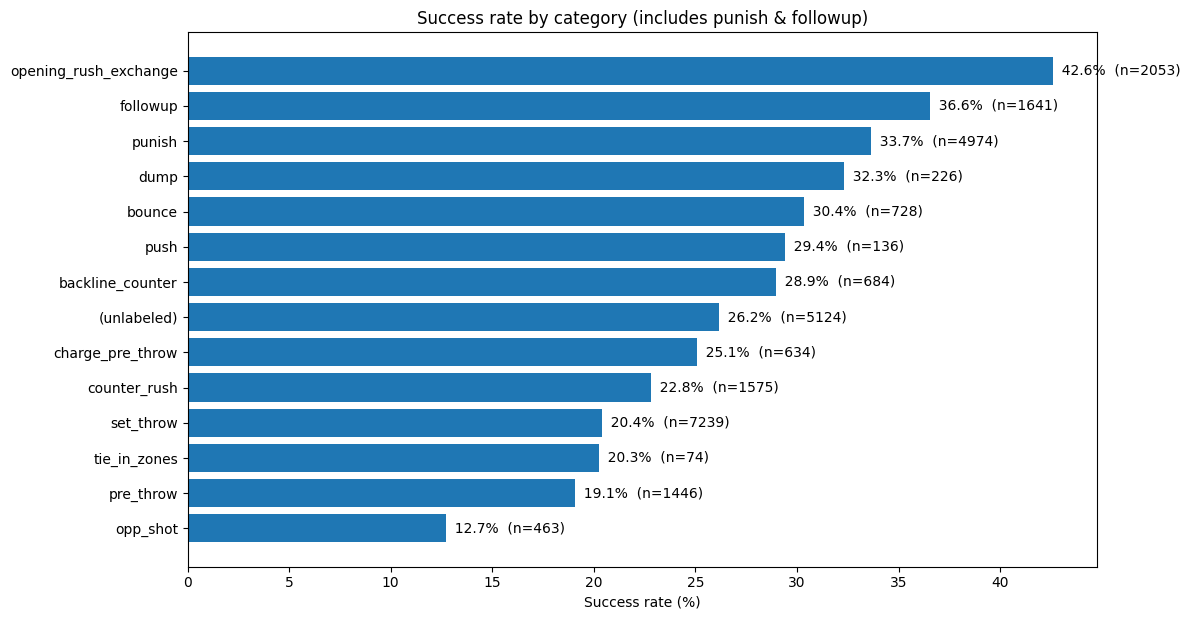

Saved plot -> /content/drive/MyDrive/Winrate predictions/success_rate_by_category.png


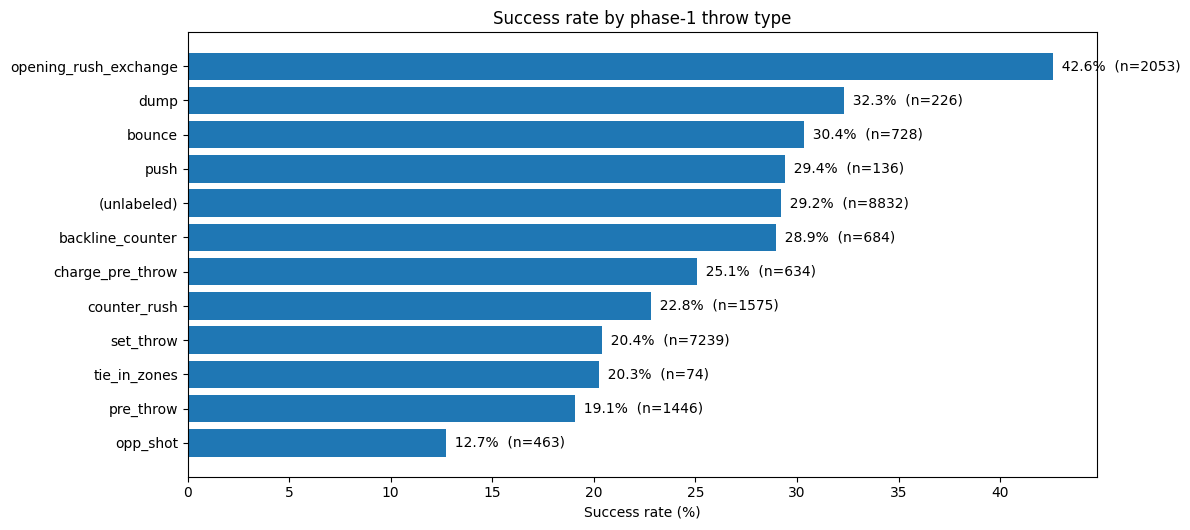

Saved plot -> /content/drive/MyDrive/Winrate predictions/success_rate_by_phase1_type.png


In [ ]:
# =======================
# Visualize success rates (bars)
# - Reads: throw_type_success_with_pf_categories.xlsx
# - Plots:
#   1) Success by category (includes 'punish' & 'followup')
#   2) Success by phase-1 throw type only
# =======================

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = '/content/drive/MyDrive/Winrate predictions'
INFILE = os.path.join(ROOT, 'throw_type_success_with_pf_categories.xlsx')

# Load sheets
by_cat  = pd.read_excel(INFILE, sheet_name='success_by_category')
by_type = pd.read_excel(INFILE, sheet_name='success_by_type')

def _clean_and_sort(df, name_col='category'):
    d = df.copy()
    # Keep rows with a defined success_rate and at least one scored sample
    d = d[(~d['success_rate'].isna()) & (d['n_scored'] > 0)].copy()
    # Sort: success rate desc, then n_scored desc
    d = d.sort_values(['success_rate', 'n_scored'], ascending=[False, False])
    # For plotting, reverse to make the top appear at the top of horizontal bar
    d = d.iloc[::-1].reset_index(drop=True)
    return d

def plot_success_bars(df, name_col, title, outfile_png):
    d = _clean_and_sort(df, name_col=name_col)
    if d.empty:
        print(f"[skip] No data to plot for {title}")
        return

    labels = d[name_col].astype(str)
    rates  = d['success_rate'].astype(float) * 100.0
    ns     = d['n_scored'].astype(int)

    plt.figure(figsize=(12, max(4, 0.45 * len(d))))
    plt.barh(labels, rates)  # use default colors (no style set)

    # Annotate bars with "xx.x% (n=###)"
    for i, (r, n) in enumerate(zip(rates, ns)):
        plt.text(r, i, f"  {r:.1f}%  (n={n})", va='center')

    plt.xlabel('Success rate (%)')
    plt.title(title)
    plt.tight_layout()
    # Save & show
    plt.savefig(outfile_png, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved plot -> {outfile_png}")

# 1) Category chart (includes 'punish' & 'followup')
plot_success_bars(
    by_cat,
    name_col='category',
    title='Success rate by category (includes punish & followup)',
    outfile_png=os.path.join(ROOT, 'success_rate_by_category.png')
)

# 2) Phase-1 type chart only
plot_success_bars(
    by_type,
    name_col='phase1_category',
    title='Success rate by phase-1 throw type',
    outfile_png=os.path.join(ROOT, 'success_rate_by_phase1_type.png')
)


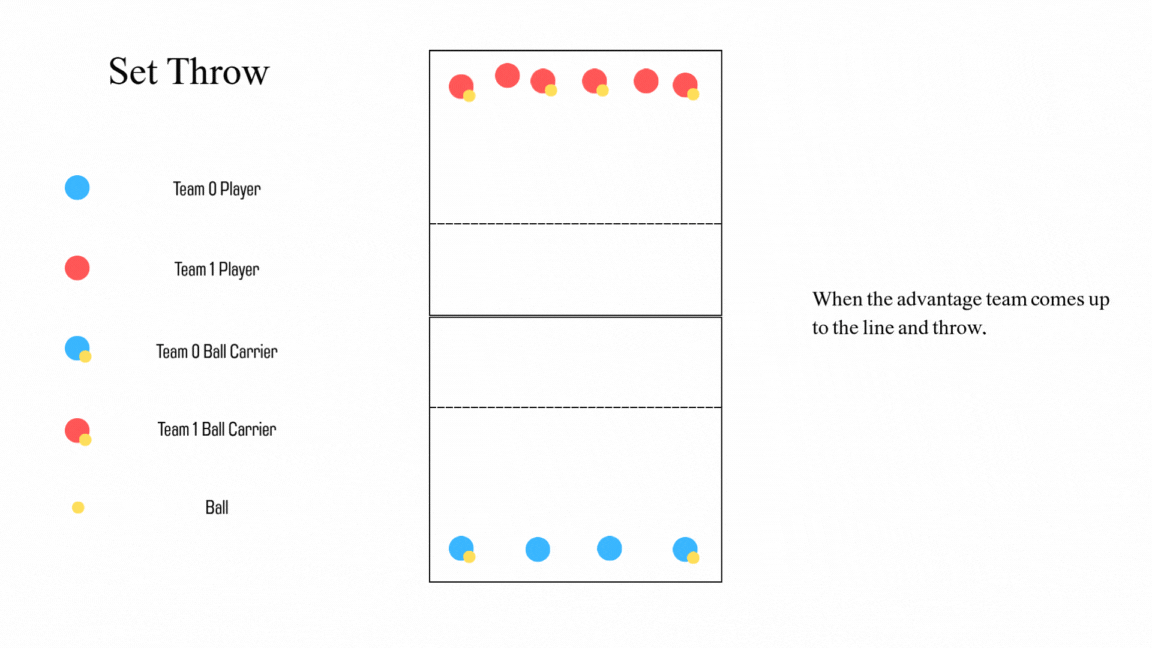

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Set Throw.gif'
Image(filename=gif_path)


In [ ]:
# =======================
# Outcomes from *paired rows at the same time* (time-only, tolerant) + independent punish/followup
# =======================
# Outcome is taken DIRECTLY from any row in the same time bucket (across both teams).
# Success = (outcome == "hit"). Time pairing uses rounded time (3 decimals) to avoid float mismatches.

from google.colab import drive
drive.mount('/content/drive')

import os, glob, re
import numpy as np
import pandas as pd

# -------- CONFIG --------
ROOT = '/content/drive/MyDrive/Winrate predictions'  # change if needed
OUT_XLSX = os.path.join(ROOT, 'throw_type_outcomes_with_punish_followup_timekey.xlsx')
TIME_DECIMALS = 3   # round time to this many decimals to form the pairing key

# -------- Helpers --------
def normalize_teams(series):
    s = pd.to_numeric(series, errors='coerce')
    return (s == 1).astype(int)  # exactly 1 -> 1, else 0

def norm_token(s: str) -> str:
    """lowercase, remove non-letters (spaces/underscores/punct/digits), e.g., 'throw_hit' -> 'throwhit'"""
    return re.sub(r'[^a-z]+', '', str(s).lower())

# Exact mapping after normalization (no substring scanning)
OUTCOME_MAP = {
    'throwhit':   'hit',
    'throwmiss':  'miss',
    'throwcatch': 'catch',
    'caught':     'catch',
    'gotcaught':  'catch',
}

def is_base_throw_row(title, definition_key):
    """
    Base throw rows: contain 'throw' somewhere but are NOT an outcome row.
    We still keep this simple: check that neither normalized title nor definitionKey matches an outcome token.
    """
    t = str(title).lower()
    d = str(definition_key).lower()
    has_throw = ('throw' in t) or ('throw' in d)
    t_norm = norm_token(title)
    d_norm = norm_token(definition_key)
    is_outcome = (t_norm in OUTCOME_MAP) or (d_norm in OUTCOME_MAP)
    return has_throw and (not is_outcome)

def outcome_from_time_group(df_group: pd.DataFrame) -> str:
    """
    Look at all rows in this time bucket (across both teams).
    If any row's normalized title/definitionKey is in OUTCOME_MAP, record outcome(s).
    If multiple outcomes, tie-break: hit > catch > miss.
    """
    found = []
    for _, rr in df_group.iterrows():
        for cand in (rr.get('definitionKey',''), rr.get('title','')):
            tok = norm_token(cand)
            if tok in OUTCOME_MAP:
                found.append(OUTCOME_MAP[tok])

    if not found:
        return 'unknown'

    # prefer hit > catch > miss if multiples exist
    for pref in ['hit', 'catch', 'miss']:
        if pref in found:
            return pref
    return found[0]

def to_bool_any(series_like) -> bool:
    if series_like is None:
        return False
    s = pd.Series(series_like)
    return s.astype(str).str.strip().str.lower().isin(['1','true','t','yes','y']).any()

def flags_from_time_group(df_group: pd.DataFrame, punish_col='is_punish', follow_col='is_followup') -> tuple[bool,bool]:
    """
    Independent flags from the time group (ANY true in the group => True).
    Priority: named columns if present; else use the group's *last two columns*.
    """
    cols = list(df_group.columns)
    if (punish_col in cols) and (follow_col in cols):
        return bool(to_bool_any(df_group[punish_col])), bool(to_bool_any(df_group[follow_col]))

    # fallback: use last two columns as punish/followup
    if len(cols) >= 2:
        return bool(to_bool_any(df_group[cols[-2]])), bool(to_bool_any(df_group[cols[-1]]))

    return False, False

# -------- Main aggregation --------
paths = glob.glob(os.path.join(ROOT, '**', '*_events_with_phase1_tags_by_nearest_time.xlsx'), recursive=True)
if not paths:
    raise FileNotFoundError("No '*_events_with_phase1_tags_by_nearest_time.xlsx' found under ROOT.")

per_throw_rows = []
unmatched_records = []  # for debugging time buckets with no detected outcome

for p in sorted(paths):
    df = pd.read_excel(p)

    # normalize essentials
    for col in ('title','definitionKey'):
        if col not in df.columns: df[col] = ''
        df[col] = df[col].astype(str)

    df['time'] = pd.to_numeric(df.get('time', np.nan), errors='coerce')
    df['team'] = normalize_teams(df.get('team', np.nan))

    # Build the time key for pairing
    df = df[df['time'].notna()].copy()
    df['time_key'] = df['time'].round(TIME_DECIMALS)

    # Identify base throws
    base_mask = df.apply(lambda r: is_base_throw_row(r['title'], r['definitionKey']), axis=1)
    base_throws = df.loc[base_mask].copy()

    # Precompute group info per time_key
    time_groups = dict(tuple(df.groupby('time_key')))
    time_info = {}  # time_key -> (outcome, is_punish, is_followup)

    for tk, g in time_groups.items():
        outc = outcome_from_time_group(g)
        is_punish, is_followup = flags_from_time_group(g)
        time_info[tk] = (outc, is_punish, is_followup)

        if outc == 'unknown':
            # collect some label hints for debugging
            raw_labels = set()
            for _, rr in g.iterrows():
                raw_labels.add(norm_token(rr.get('definitionKey','')))
                raw_labels.add(norm_token(rr.get('title','')))
            unmatched_records.append({
                'source_file': os.path.basename(p),
                'time_key': float(tk),
                'unique_norm_labels_in_group': ', '.join(sorted([x for x in raw_labels if x]))
            })

    # Attach to each base throw
    for _, r in base_throws.iterrows():
        tk = float(r['time_key'])
        outcome, is_punish, is_followup = time_info.get(tk, ('unknown', False, False))
        per_throw_rows.append({
            'source_file': os.path.basename(p),
            'time': float(r['time']),
            'time_key': tk,
            'team': int(r['team']) if pd.notna(r['team']) else np.nan,
            'phase1_category': r.get('phase1_category', np.nan),
            'outcome': outcome,                  # hit / catch / miss / unknown
            'success': (outcome == 'hit'),       # success = hit
            'is_punish': is_punish,              # independent flag
            'is_followup': is_followup           # independent flag
        })

# ---- Build per-throw DataFrame ----
throws = pd.DataFrame(per_throw_rows)
throws['phase1_category'] = throws['phase1_category'].astype(object)
throws.loc[throws['phase1_category'].isna(), 'phase1_category'] = '(unlabeled)'

# ---- Summary 1: per type outcomes & success ----
outcomes = pd.crosstab(throws['phase1_category'], throws['outcome']).reset_index()
for col in ['hit','catch','miss','unknown']:
    if col not in outcomes.columns: outcomes[col] = 0
outcomes['n'] = outcomes[['hit','catch','miss','unknown']].sum(axis=1)
outcomes['hit_rate'] = outcomes['hit'] / outcomes['n'].replace(0, np.nan)
outcomes['catch_rate'] = outcomes['catch'] / outcomes['n'].replace(0, np.nan)
outcomes['miss_rate'] = outcomes['miss'] / outcomes['n'].replace(0, np.nan)
outcomes['success_rate'] = outcomes['hit_rate']  # success = hit

# ---- Summary 2: per type, independent punish/followup success ----
def flag_subset_rates(df, flag_col):
    sub = (
        df[df[flag_col] == True]
        .groupby('phase1_category', dropna=False)
        .agg(
            n=(flag_col, 'size'),
            hits=('success', 'sum'),
            success_rate=('success', 'mean')
        ).reset_index()
    )
    sub.rename(columns={
        'n': f'{flag_col}_n_in_type',
        'hits': f'{flag_col}_hits_in_type',
        'success_rate': f'{flag_col}_success_rate_in_type'
    }, inplace=True)
    return sub

punish_in_type = flag_subset_rates(throws, 'is_punish')
follow_in_type = flag_subset_rates(throws, 'is_followup')

by_type_outcomes = (
    outcomes
    .merge(punish_in_type, on='phase1_category', how='left')
    .merge(follow_in_type, on='phase1_category', how='left')
)
for c in [c for c in by_type_outcomes.columns if c.endswith('_n_in_type') or c in ['hit','catch','miss','unknown','n']]:
    by_type_outcomes[c] = by_type_outcomes[c].fillna(0).astype(int)

# ---- Summary 3: global independent flags ----
def global_flag_summary(df, flag_col):
    mask = df[flag_col] == True
    n = int(mask.sum())
    hits = int(df.loc[mask, 'success'].sum())
    rate = float(df.loc[mask, 'success'].mean()) if n > 0 else np.nan
    return {'type': flag_col.replace('is_',''), 'n': n, 'hits': hits, 'success_rate': rate}

independent_types_global = pd.DataFrame([
    global_flag_summary(throws, 'is_punish'),
    global_flag_summary(throws, 'is_followup'),
])

# ---- Unmatched time buckets (to help you spot labels the mapper didn't catch) ----
unmatched_df = pd.DataFrame(unmatched_records).drop_duplicates().sort_values(['source_file','time_key'])

# ---- Save everything ----
with pd.ExcelWriter(OUT_XLSX, engine='openpyxl') as w:
    throws.to_excel(w, index=False, sheet_name='per_throw_debug')
    by_type_outcomes.to_excel(w, index=False, sheet_name='by_type_outcomes')
    independent_types_global.to_excel(w, index=False, sheet_name='independent_types_global')
    unmatched_df.to_excel(w, index=False, sheet_name='unmatched_time_groups')

print("Saved:", OUT_XLSX)
print("\n=== by_type_outcomes (preview) ===")
print(by_type_outcomes.head(12).to_string(index=False))
print("\n=== independent_types_global ===")
print(independent_types_global.to_string(index=False))
print("\nUnmatched time groups (first 10):")
print(unmatched_df.head(10).to_string(index=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved: /content/drive/MyDrive/Winrate predictions/throw_type_outcomes_with_punish_followup_timekey.xlsx

=== by_type_outcomes (preview) ===
      phase1_category  hit  miss  unknown  catch    n  hit_rate  catch_rate  miss_rate  success_rate  is_punish_n_in_type  is_punish_hits_in_type  is_punish_success_rate_in_type  is_followup_n_in_type  is_followup_hits_in_type  is_followup_success_rate_in_type
          (unlabeled)   10     7     1479      0 1496  0.006684         0.0   0.004679      0.006684                    0                     NaN                             NaN                      0                       NaN                               NaN
     backline_counter    2     1      119      0  122  0.016393         0.0   0.008197      0.016393                    0                     NaN                             NaN                      0         

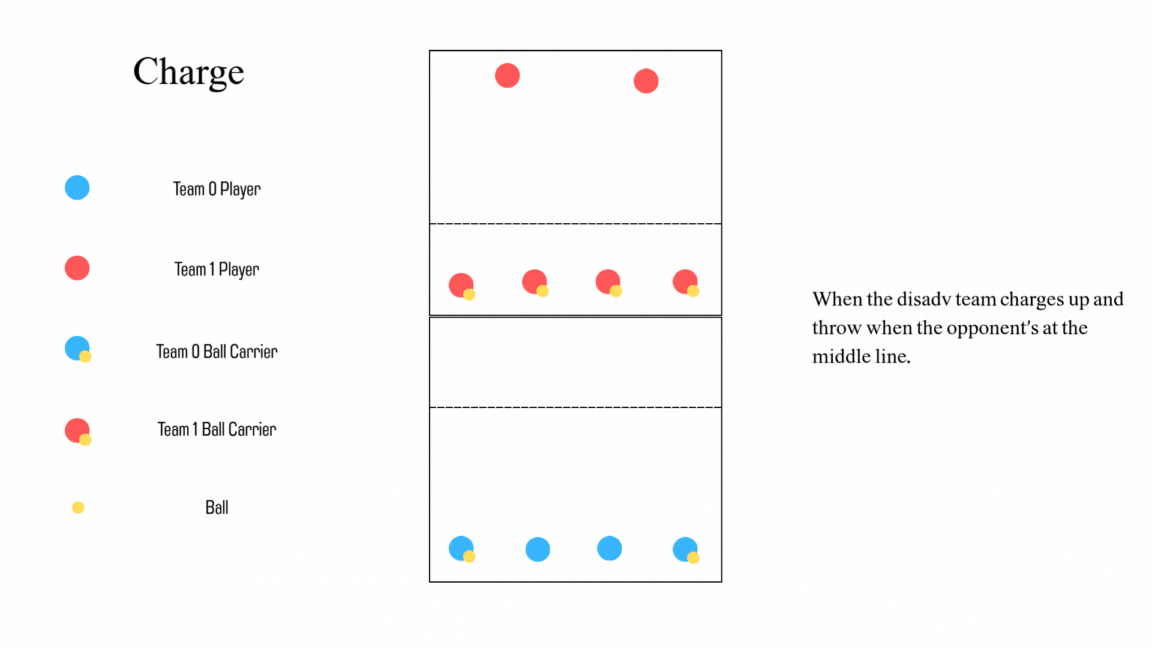

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Charge.gif'
Image(filename=gif_path)


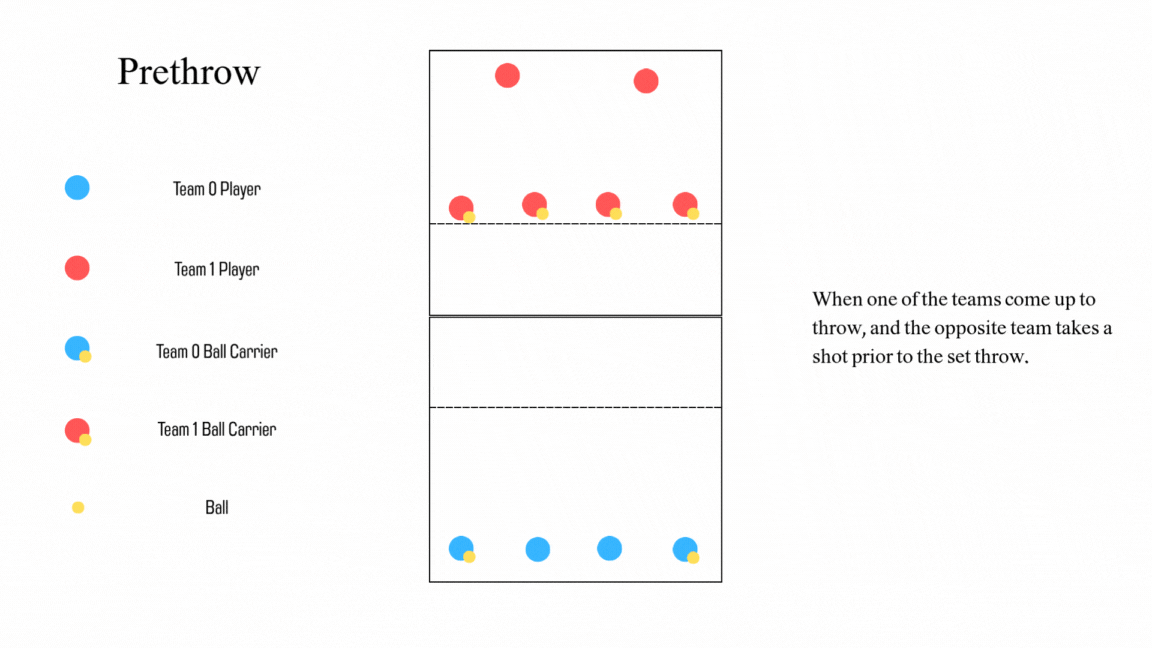

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Prethrow.gif'
Image(filename=gif_path)


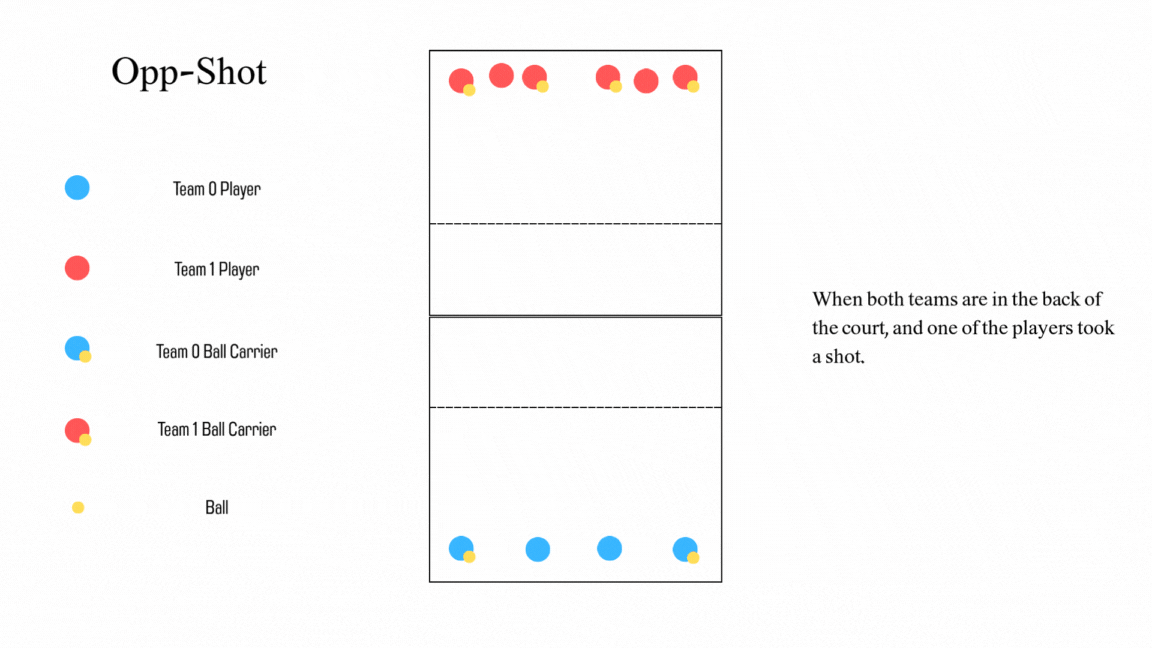

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Opp-Shot.gif'
Image(filename=gif_path)


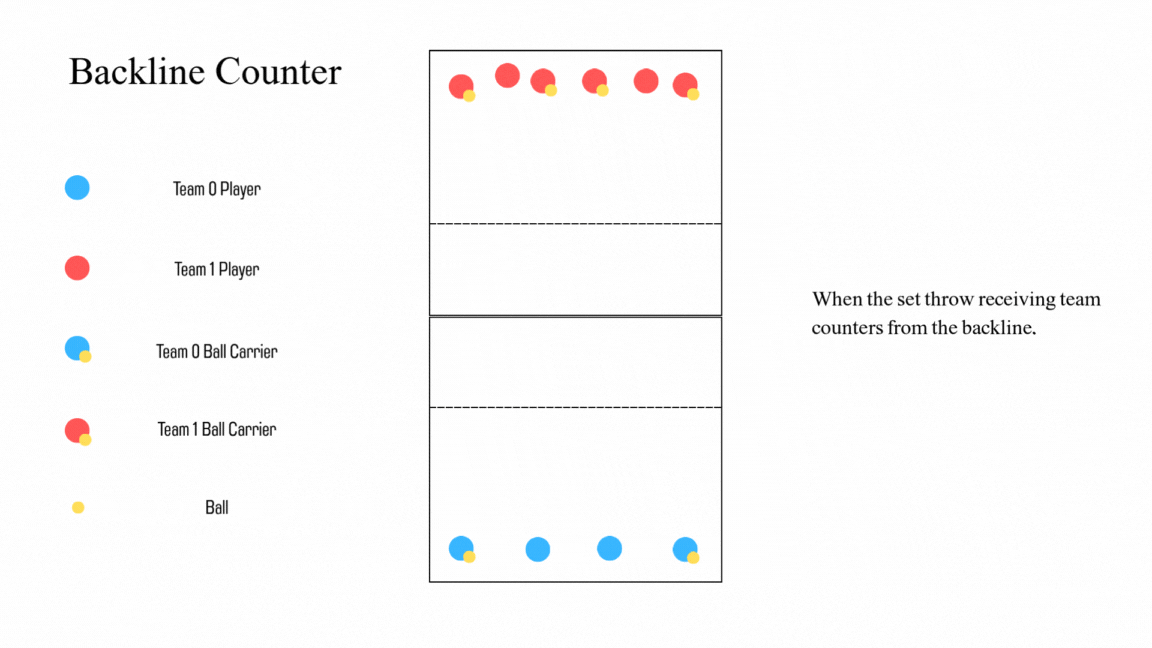

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Backline Counter.gif'
Image(filename=gif_path)


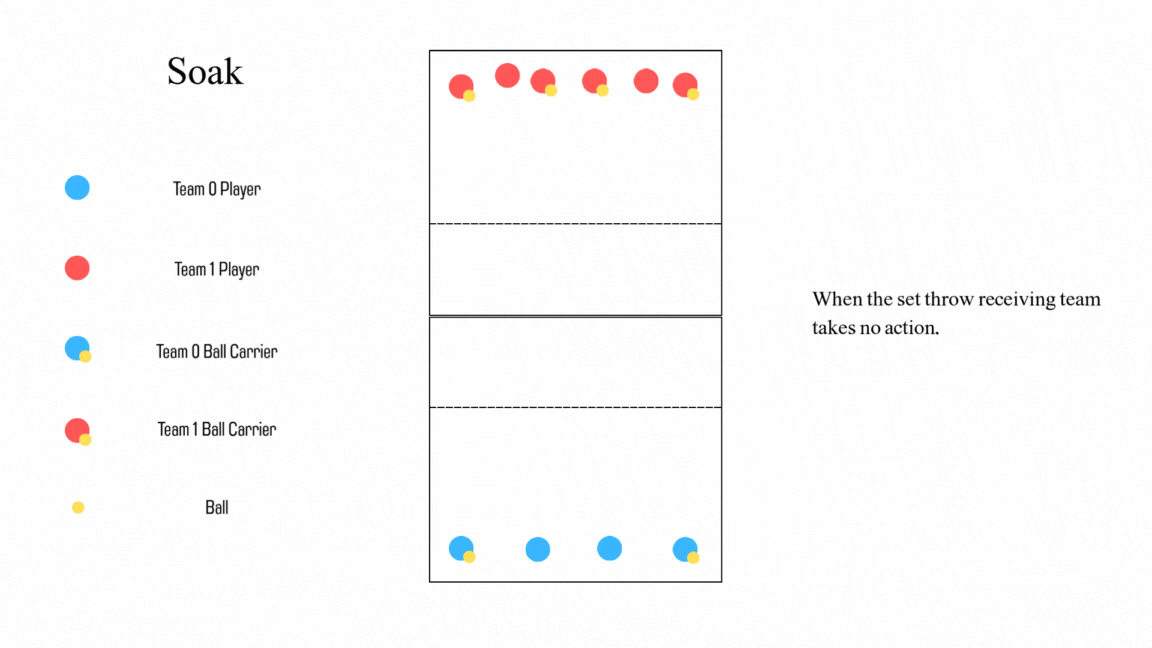

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Soak.gif'
Image(filename=gif_path)


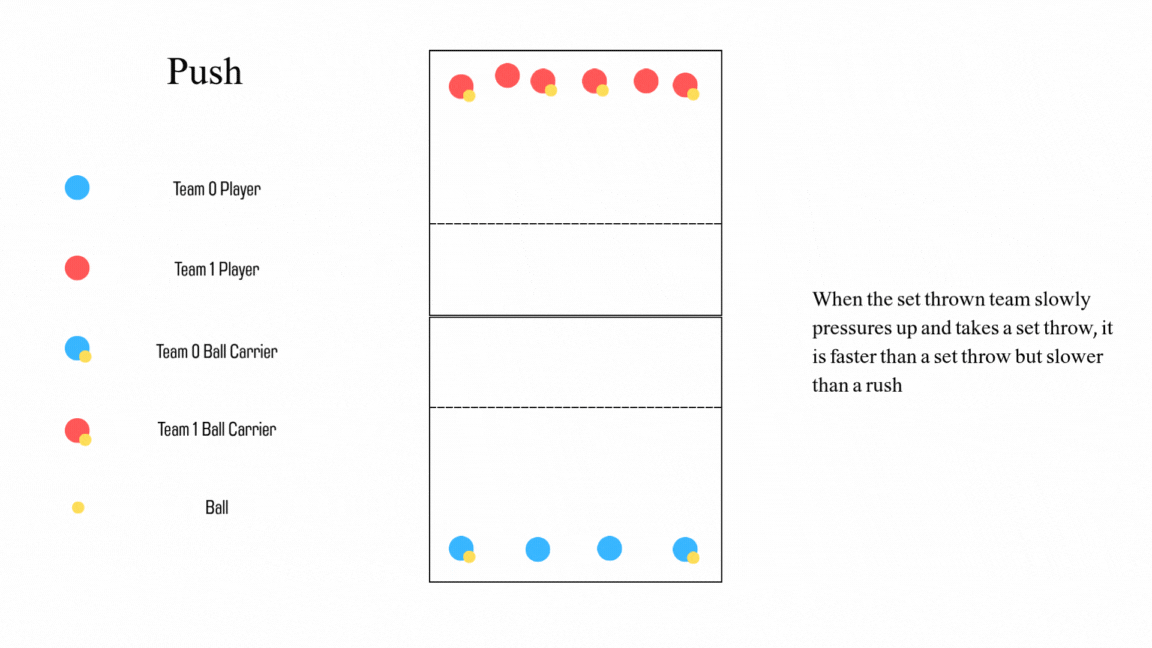

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Push.gif'
Image(filename=gif_path)


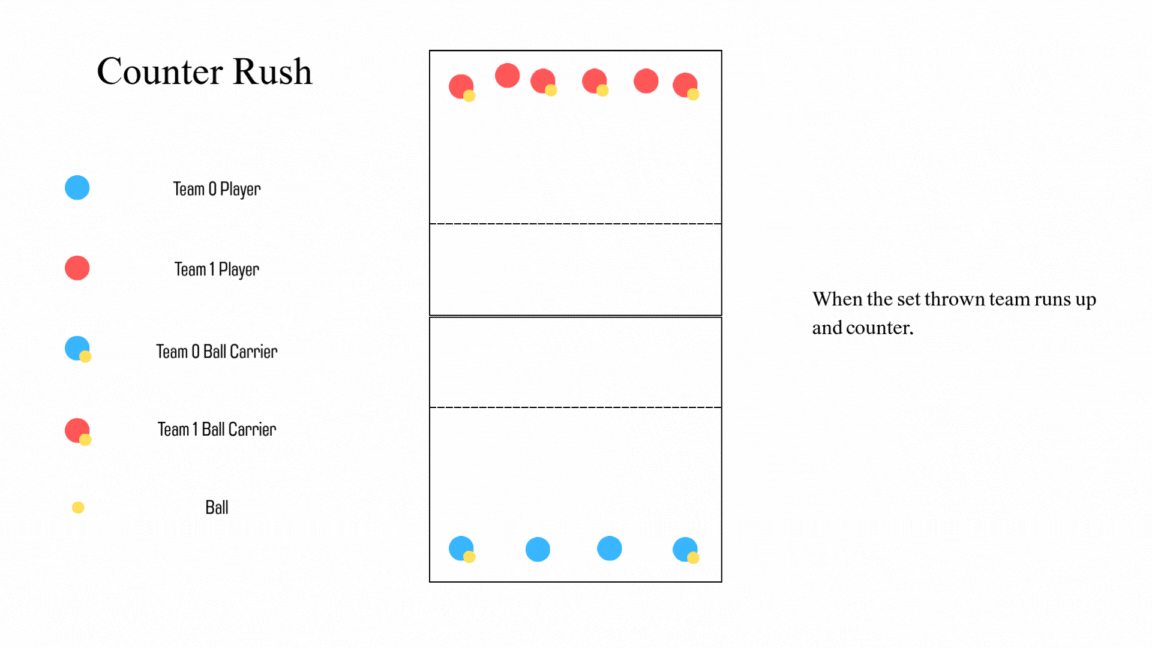

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Counter Rush.gif'
Image(filename=gif_path)


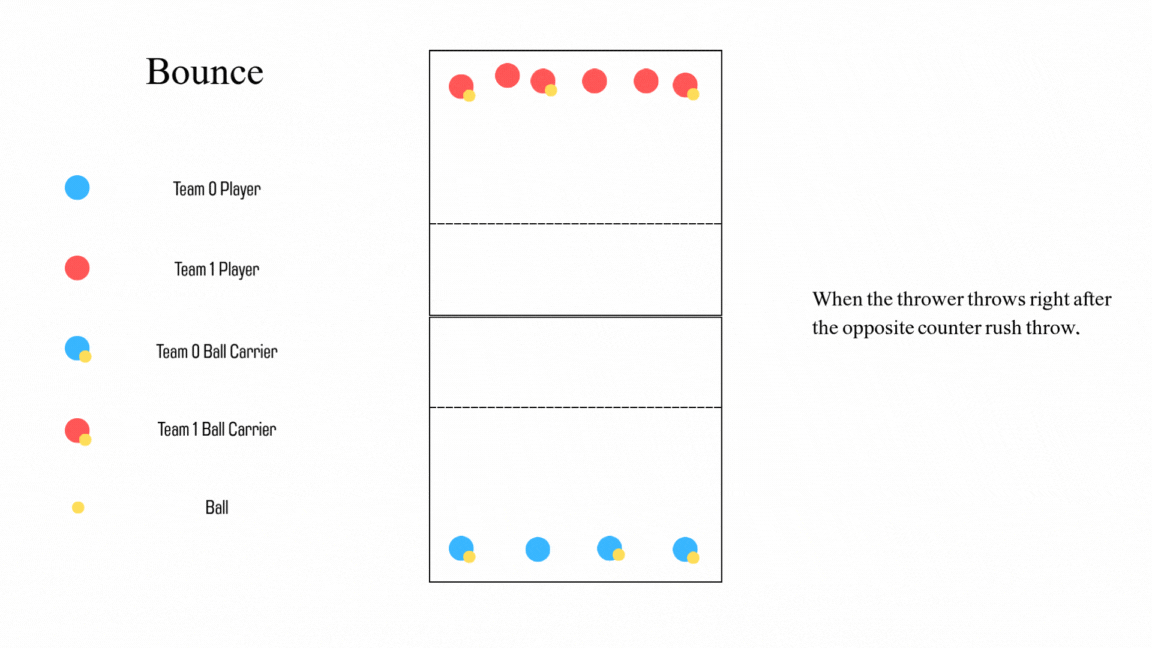

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Bounce.gif'
Image(filename=gif_path)


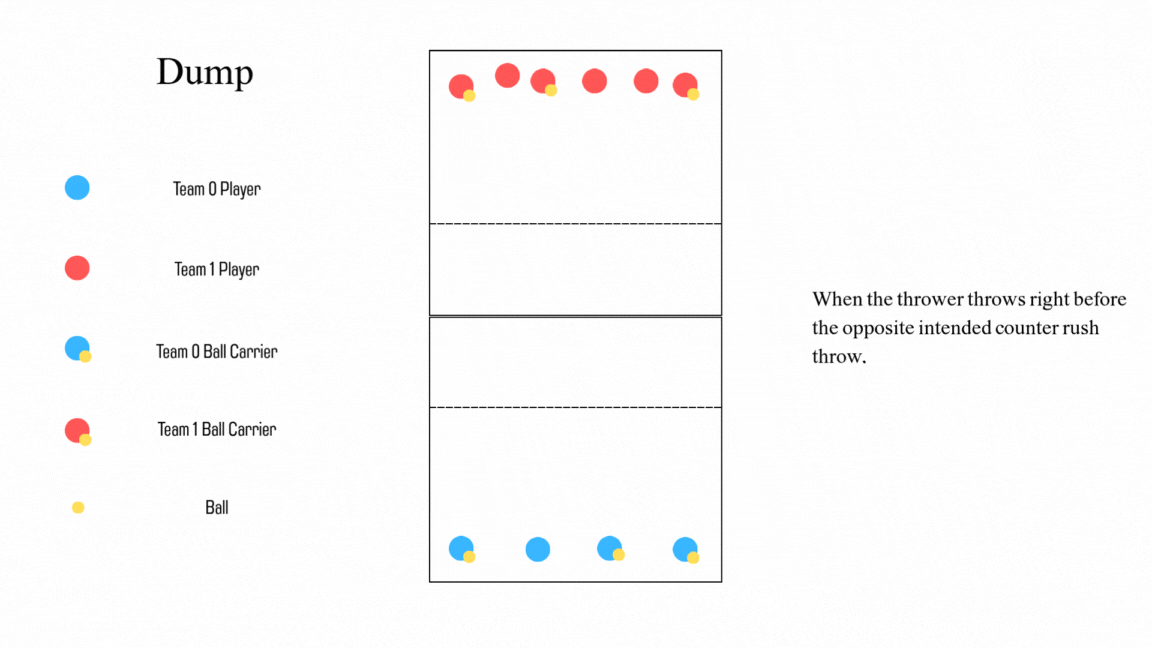

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Dump.gif'
Image(filename=gif_path)


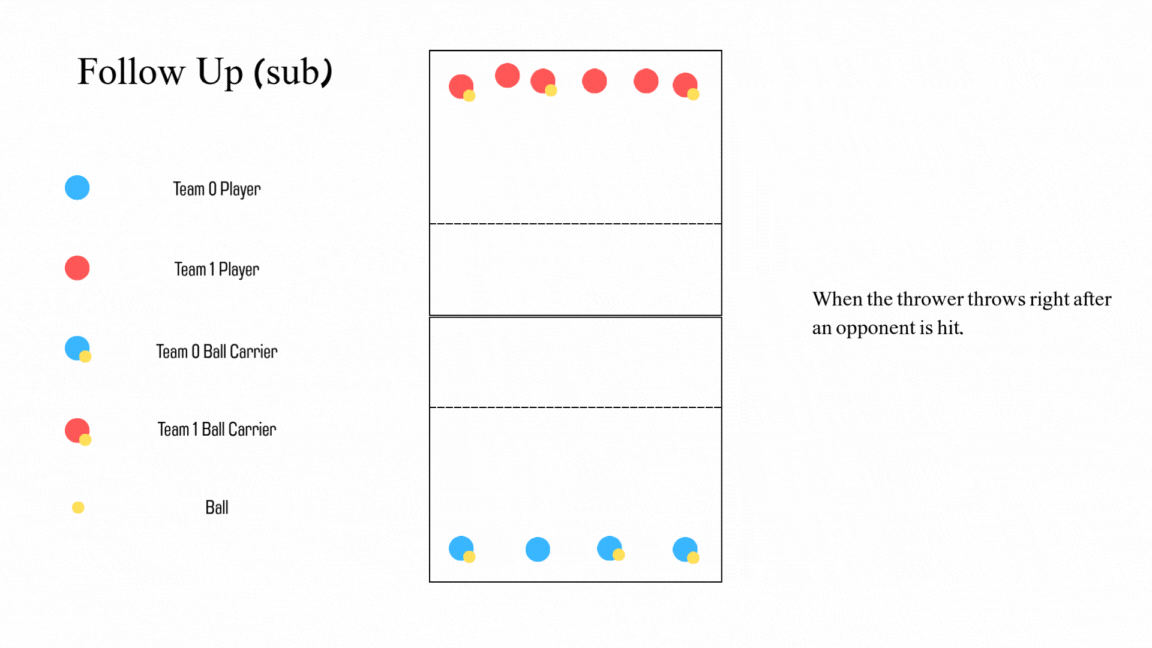

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Follow Up .gif'
Image(filename=gif_path)


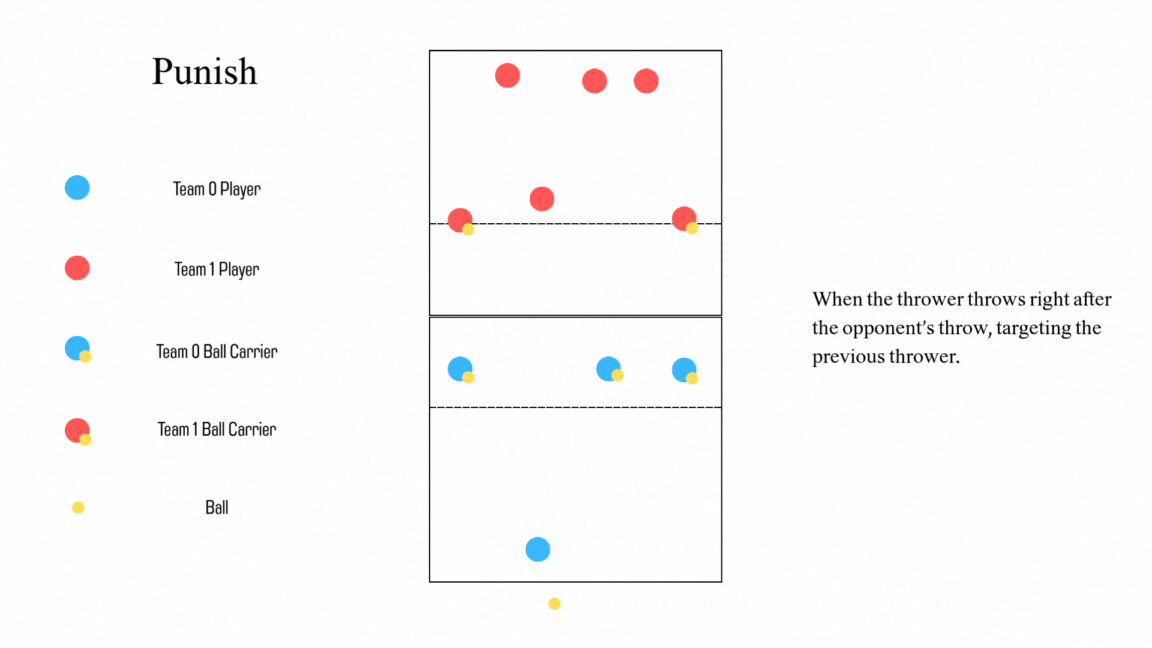

In [ ]:
from IPython.display import Image

gif_path = '/content/drive/MyDrive/Winrate predictions/Throw Type Examples/Punsih.gif'
Image(filename=gif_path)
